In [1]:
import pyedflib
import mne
import numpy as np

import torchvision
import torchaudio
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau


import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.ticker as ticker
from os import listdir
import os

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

# Collecting Data

In [2]:
def ReadSignal(file_name): 

    f = pyedflib.EdfReader(file_name)
    n = f.signals_in_file
    signal_labels = f.getSignalLabels()
    sigbufs = np.zeros((20, f.getNSamples()[0])) #or n
    print(file_name, n)
    
    if n == 22:
        for i in np.arange(19):
            sigbufs[i, :] = f.readSignal(i)
        sigbufs[19, :] = f.readSignal(21)
    elif n == 23:
        for i in np.arange(19):
            sigbufs[i, :] = f.readSignal(i)
        sigbufs[19, :] = f.readSignal(20)
    elif n == 21:
        for i in np.arange(20):
            sigbufs[i, :] = f.readSignal(i)
    else:
        for i in np.arange(n):
            sigbufs[i, :] = f.readSignal(i)

    time = [1/f.samplefrequency(0) * i for i in range(len(sigbufs[0]))]

    annotations = f.readAnnotations()  

    new_annot = [(annotations[0][i], annotations[1][i], annotations[2][i])  
                 for i in range(len(annotations[0])) 
                                if (annotations[1][i] > 0) and (annotations[2][i] in ["Ð´Ð°Ð±Ð» Ñ\x81Ð¿Ð°Ð¹Ðº", "*", "?", "F7", 
                                                                                      'Ð\xa03(blockUserBlock)', "F7(blockUserBlock)", 
                                                                                      "O2(blockUserBlock)", "F7(blockUserBlock)", 
                                                                                      'Ð¡4(blockUserBlock)', 'Ñ\x8dÐ°',
                                                                                      "F7(blockUserBlock)(blockUserBlock)"])]
    f.close()
    return sigbufs, new_annot, time, f.samplefrequency(0)

In [3]:
record_names = ["NNSpecialistsData/1.edf",
                "NNSpecialistsData/-2 marked.edf",
                "NNSpecialistsData/-3 marked.edf", 
                "NNSpecialistsData/patient4.edf", 
                "NNSpecialistsData/5_marked.edf",
                "NNSpecialistsData/DDD.edf", 
                "NNSpecialistsData/SDA.edf", 
                "NNSpecialistsData/SVV.edf", 
                "NNSpecialistsData/ZSV.edf", 
                
                "MoscowSpecialistsData/P1.edf",
                "MoscowSpecialistsData/P1_2.edf",
                "MoscowSpecialistsData/P2.edf", 
                "MoscowSpecialistsData/P3.edf", 
                "MoscowSpecialistsData/P4.edf", 
                "MoscowSpecialistsData/P5.edf", 
                "MoscowSpecialistsData/P6.edf", 
                "MoscowSpecialistsData/P9.edf", 
                "MoscowSpecialistsData/P10.edf", 
                "MoscowSpecialistsData/P11.edf", 
                "MoscowSpecialistsData/P12.edf"]

records = []
annots = []
times = []
freqs = []
for file_name in record_names:

    sigbufs, new_annot, time, freq = ReadSignal("data/"+file_name)
    records.append(sigbufs)
    annots.append(new_annot)
    times.append(time)
    freqs.append(freq)
    

data/NNSpecialistsData/1.edf 20
data/NNSpecialistsData/-2 marked.edf 23
data/NNSpecialistsData/-3 marked.edf 23
data/NNSpecialistsData/patient4.edf 21
data/NNSpecialistsData/5_marked.edf 23
data/NNSpecialistsData/DDD.edf 23
data/NNSpecialistsData/SDA.edf 21
data/NNSpecialistsData/SVV.edf 21
data/NNSpecialistsData/ZSV.edf 23
data/MoscowSpecialistsData/P1.edf 20
data/MoscowSpecialistsData/P1_2.edf 20
data/MoscowSpecialistsData/P2.edf 20
data/MoscowSpecialistsData/P3.edf 20
data/MoscowSpecialistsData/P4.edf 20
data/MoscowSpecialistsData/P5.edf 20
data/MoscowSpecialistsData/P6.edf 20
data/MoscowSpecialistsData/P9.edf 20
data/MoscowSpecialistsData/P10.edf 20
data/MoscowSpecialistsData/P11.edf 20
data/MoscowSpecialistsData/P12.edf 20


In [4]:
def NormalizeAndClip(data):
    for i in tqdm(range(len(data))):
        signal = data[i]
        means = signal.mean(axis=1)[..., None]
        stds = signal.std(axis=1)[..., None]
        signal = np.clip((signal - means) / stds, a_min=-10, a_max=10)
        data[i] = signal

In [5]:
NormalizeAndClip(records)

100%|███████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.01s/it]


In [33]:
freqs

[199.50124688279303,
 199.50124688279303,
 199.50124688279303,
 199.50124688279303,
 199.50124688279303,
 199.50124688279303,
 199.50124688279303,
 199.50124688279303,
 199.50124688279303,
 199.50124688279303,
 199.50124688279303,
 199.50124688279303,
 199.50124688279303,
 199.50124688279303,
 199.50124688279303,
 199.50124688279303,
 199.50124688279303,
 199.50124688279303,
 199.50124688279303,
 199.50124688279303]

In [7]:
def Transform(sample_rate): # only for 199
    transform = 0
    new_freq = 0
    if sample_rate == 199:
        transform500 = torchaudio.transforms.Resample(250625, 100000)
        transform1000 = torchaudio.transforms.Resample(50125, 10000)
        
        new_freq = 80000 / 401
    else:
        transform = torchaudio.transforms.Resample(100000, 250625) 
        new_freq = 500
    for i in range(len(records)):
        if int(freqs[i]) != sample_rate:
            if int(freqs[i]) == 500:
                new_sigbufs = []
                sigbufs = records[i]
                for sig in tqdm(sigbufs):
                    new_sigbufs.append(transform500(torch.FloatTensor(sig)))
                new_sigbufs = np.array(new_sigbufs)
                records[i] = new_sigbufs
                freqs[i] = new_freq
                times[i] = [1/new_freq * j for j in range(len(new_sigbufs[0]))]   
            elif int(freqs[i]) == 1000:
                new_sigbufs = []
                sigbufs = records[i]
                for sig in tqdm(sigbufs):
                    new_sigbufs.append(transform1000(torch.FloatTensor(sig)))
                new_sigbufs = np.array(new_sigbufs)
                records[i] = new_sigbufs
                freqs[i] = new_freq
                times[i] = [1/new_freq * j for j in range(len(new_sigbufs[0]))]

In [8]:
Transform(199)

100%|███████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 35.39it/s]


In [9]:
for i in range(len(freqs)):
    freqs[i] = 80000 / 401
    times[i] = [1/freqs[i] * j for j in range(len(records[i][0]))]

In [10]:
def Labeling(time, events_lst):
    labels = np.zeros_like(time)

    for events in events_lst:
        for event in tqdm(events):
            start = np.array(time < event[0]).argmin()
            fin = np.array(time < event[0] + event[1]).argmin()
            labels[start:fin] =  1
    return labels
        

In [11]:
# all_labels = []
# for i in range(len(records)):
#     name = "data/" + record_names[i].split("/")[0] + "/Labels/" + record_names[i].split("/")[1] + "freq" + str(freqs[i])[:3]
#     if "NN" in record_names[i] and not os.path.exists(name + ".npy"):
#         labels = Labeling(times[i], [annots[i]])
#         np.save(name, labels)
#     elif "Moscow" in record_names[i] and not os.path.exists(name + ".npy"):
#         labels = Labeling(times[i], [annots[i]])
#         np.save(name, labels)

In [12]:
all_labels = []

for i in range(len(records)):
    name = "data/" + record_names[i].split("/")[0] + "/Labels/" + record_names[i].split("/")[1] + "freq" + str(freqs[i])[:3]
    if "NN" in record_names[i]:
        all_labels.append(np.load(name + ".npy"))
    elif "Moscow" in record_names[i]:
        all_labels.append(np.load(name + ".npy"))

In [13]:
all_sneo = []
all_mc = []


for i in range(len(records)):
    name_sneo = "data/" + record_names[i].split("/")[0] + "/SNEO/" + record_names[i].split("/")[1] + "freq" + str(freqs[i])[:3]
    name_mc = "data/" + record_names[i].split("/")[0] + "/MC/" + record_names[i].split("/")[1] + "freq" + str(freqs[i])[:3]
    
    if "NN" in record_names[i]:
        all_sneo.append(np.load(name_sneo + ".npy"))
        all_mc.append(np.load(name_mc + ".npy"))
        
    elif "Moscow" in record_names[i]:
        all_sneo.append(np.load(name_sneo + ".npy"))
        all_mc.append(np.load(name_mc + ".npy"))
        

In [14]:
for i in range(len(records)):
    assert all_sneo[i].shape == records[i].shape
    assert all_mc[i].shape == records[i].shape    

# Train Test Split

In [15]:
def Shuffle(records):
    shuffled_records = []
    for i in range(len(records)):
        shuffled_records.append(records[i].copy())
        np.random.shuffle(shuffled_records[-1][:-1])
    return shuffled_records

In [16]:
def GetTrainTestByIdxs(array, train_indices):
    train_array = [array[idx] for idx, is_train in enumerate(train_indices) if is_train == True]
    test_array = [array[idx] for idx, is_train in enumerate(train_indices) if is_train == False]    
    return train_array, test_array

def GetTrainTestSplit(records, annots, times, labels, index, shuffle_leads, N, sneos=None, mcs=None):
    train_indices = np.ones(N) #number of records
    if N %2 == 1 and index == N // 2 + 1:
        train_indices[-1] = 0
    else:
        train_indices[2*index: 2*index+2] = 0
        
    train_sneos, test_sneos = None, None
    train_mcs, test_mcs = None, None
    
    train_records, test_records = GetTrainTestByIdxs(records, train_indices)
    if sneos is not None:
        train_sneos, test_sneos = GetTrainTestByIdxs(sneos, train_indices)
        train_mcs, test_mcs = GetTrainTestByIdxs(mcs, train_indices)
        
        
    train_labels, test_labels = GetTrainTestByIdxs(labels, train_indices)  
    train_annots, test_annots = GetTrainTestByIdxs(annots, train_indices)
    train_times, test_times = GetTrainTestByIdxs(times, train_indices)
    
    
    if shuffle_leads:
        train_records = Shuffle(train_records)
    
    train_data = []
    for i in range(len(train_records)):
        train_time_start = train_annots[i][0][0]
        train_time_end = train_annots[i][-1][0]
        train_idx_start = (np.array(train_times[i]) < train_time_start).argmin()
        train_idx_fin = (np.array(train_times[i])< train_time_end).argmin()
        
        if sneos is not None:
            train_data.append((torch.FloatTensor(train_records[i][:, train_idx_start:train_idx_fin]), 
                              torch.FloatTensor(train_sneos[i][:, train_idx_start:train_idx_fin]), 
                              torch.FloatTensor(train_mcs[i][:, train_idx_start:train_idx_fin])))
        else:
            train_data.append((torch.FloatTensor(train_records[i][:, train_idx_start:train_idx_fin]), None, None))
        
        current_labels = train_labels[i][train_idx_start:train_idx_fin]
        new_trainl = torch.zeros(2, len(current_labels))
        new_trainl = (torch.arange(2) == torch.LongTensor(current_labels)[:,None]).T
        new_trainl = new_trainl.float()
        train_labels[i] = new_trainl
    
    test_data = []
    for i in range(len(test_records)):
        test_time_start = test_annots[i][0][0]
        test_time_end = test_annots[i][-1][0]
        test_idx_start = (np.array(test_times[i]) < test_time_start).argmin()
        test_idx_fin = (np.array(test_times[i])< test_time_end).argmin()

        if sneos is not None:
            test_data.append((torch.FloatTensor(test_records[i][:, test_idx_start:test_idx_fin]), 
                              torch.FloatTensor(test_sneos[i][:, test_idx_start:test_idx_fin]), 
                              torch.FloatTensor(test_mcs[i][:, test_idx_start:test_idx_fin])))
        else:
            test_data.append((torch.FloatTensor(test_records[i][:, test_idx_start:test_idx_fin]), None, None))                  
        
        current_labels = test_labels[i][test_idx_start:test_idx_fin]
        new_testl = torch.zeros(2, len(current_labels))
        new_testl = (torch.arange(2) == torch.LongTensor(current_labels)[:,None]).T
        new_testl = new_testl.float()
        test_labels[i] = new_testl
    
    return train_data, train_labels, test_data, test_labels

In [17]:
RECEPTIVE_FIELD = 4000
OVERLAP = 0 

def CreateSamples(x, labels, rf = RECEPTIVE_FIELD, ov = OVERLAP, sneo=None, mc=None):
    inout_seq = []
    L = x.shape[-1]
    if sneo != None:
        for i in tqdm(range(ov, L- rf - ov, rf)):
            train_seq = x[:, i-ov:i+rf+ov]
            train_sneo = sneo[:, i-ov:i+rf+ov]
            train_mc = mc[:, i-ov:i+rf+ov]
            
            train_label = labels[:, i:i+rf]
            inout_seq.append((train_seq, train_sneo, train_mc, train_label))
    else:
        for i in tqdm(range(ov, L- rf - ov, rf)):
            train_seq = x[:, i-ov:i+rf+ov]
            train_label = labels[:, i:i+rf]
            inout_seq.append((train_seq, "None", "None", train_label)) #with real None problems with dataloader
  
    return inout_seq
    

#  Net and Training

In [18]:
class conbr_block(nn.Module):
    def __init__(self, in_layer, out_layer, kernel_size, stride, dilation):
        super(conbr_block, self).__init__()

        self.conv1 = nn.Conv1d(in_layer, out_layer, kernel_size=kernel_size, stride=stride, dilation = dilation, padding = 3, bias=True)
        self.bn = nn.BatchNorm1d(out_layer)
        self.relu = nn.ReLU()
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.bn(x)
        out = self.relu(x)
        
        return out       

class se_block(nn.Module):
    def __init__(self,in_layer, out_layer):
        super(se_block, self).__init__()
        
        self.conv1 = nn.Conv1d(in_layer, out_layer//8, kernel_size=1, padding=0)
        self.conv2 = nn.Conv1d(out_layer//8, in_layer, kernel_size=1, padding=0)
        self.fc = nn.Linear(1,out_layer//8)
        self.fc2 = nn.Linear(out_layer//8,out_layer)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,x):

        x_se = nn.functional.adaptive_avg_pool1d(x,1)
        x_se = self.conv1(x_se)
        x_se = self.relu(x_se)
        x_se = self.conv2(x_se)
        x_se = self.sigmoid(x_se)
        
        x_out = torch.add(x, x_se)
        return x_out

class re_block(nn.Module):
    def __init__(self, in_layer, out_layer, kernel_size, dilation):
        super(re_block, self).__init__()
        
        self.cbr1 = conbr_block(in_layer,out_layer, kernel_size, 1, dilation)
        self.cbr2 = conbr_block(out_layer,out_layer, kernel_size, 1, dilation)
        self.seblock = se_block(out_layer, out_layer)
    
    def forward(self,x):

        x_re = self.cbr1(x)
        x_re = self.cbr2(x_re)
        x_re = self.seblock(x_re)
        x_out = torch.add(x, x_re)
        return x_out          

class UNET_1D(nn.Module):
    def __init__(self ,input_dim,layer_n,kernel_size,depth, n_features=1):
        super(UNET_1D, self).__init__()
        self.input_dim = input_dim
        self.layer_n = layer_n
        self.kernel_size = kernel_size
        self.depth = depth
        
        self.AvgPool1D1 = nn.AvgPool1d(input_dim, stride=5, padding=8)
        self.AvgPool1D2 = nn.AvgPool1d(input_dim, stride=25, padding=8)
        #self.AvgPool1D3 = nn.AvgPool1d(input_dim, stride=125, padding=8)
        
        self.layer1 = self.down_layer(self.input_dim, self.layer_n, self.kernel_size,1, 2)
        self.layer1_sneo = self.down_layer(self.input_dim, self.layer_n, self.kernel_size,1, 2)
        self.layer1_mc = self.down_layer(self.input_dim, self.layer_n, self.kernel_size,1, 2)
        
        self.layer2 = self.down_layer(self.layer_n, int(self.layer_n*2), self.kernel_size,5, 2)
        self.layer3 = self.down_layer(int(self.layer_n*2)+n_features*int(self.input_dim), int(self.layer_n*3), self.kernel_size,5, 2)
        self.layer4 = self.down_layer(int(self.layer_n*3)+n_features*int(self.input_dim), int(self.layer_n*4), self.kernel_size,5, 2)
        #self.layer5 = self.down_layer(int(self.layer_n*4)+n_features*int(self.input_dim), int(self.layer_n*5), self.kernel_size,4, 2)

        self.cbr_up1 = conbr_block(int(self.layer_n*7), int(self.layer_n*3), self.kernel_size, 1, 1)
        self.cbr_up2 = conbr_block(int(self.layer_n*5), int(self.layer_n*2), self.kernel_size, 1, 1)
        self.cbr_up3 = conbr_block(int(self.layer_n*3), self.layer_n, self.kernel_size, 1, 1)
        self.upsample = nn.Upsample(scale_factor=5, mode='nearest')
        self.upsample1 = nn.Upsample(scale_factor=5, mode='nearest') #for 4000 it is 5 and for 100 is 4
        
        self.outcov = nn.Conv1d(self.layer_n, 2, kernel_size=self.kernel_size, stride=1,padding = 3)
    
        
    def down_layer(self, input_layer, out_layer, kernel, stride, depth):
        block = []
        block.append(conbr_block(input_layer, out_layer, kernel, stride, 1))
        for i in range(depth):
            block.append(re_block(out_layer,out_layer,kernel,1))
        return nn.Sequential(*block)
    
            
    def forward(self, x, sneo=None, mc=None):
        
        if sneo is not None:
            pool_x1 = self.AvgPool1D1(x)
            pool_sneo1 = self.AvgPool1D1(sneo)
            pool_mc1 = self.AvgPool1D1(mc)


            pool_x2 = self.AvgPool1D2(x)
            pool_sneo2 = self.AvgPool1D2(sneo)
            pool_mc2 = self.AvgPool1D2(mc)


            #############Encoder#####################

            out_0 = self.layer1(x)
            out_0_sneo = self.layer1_sneo(sneo)
            out_0_mc = self.layer1_mc(mc)

            out_1 = self.layer2(out_0 + out_0_sneo + out_0_mc)        


            x = torch.cat([out_1,pool_x1, pool_sneo1, pool_mc1],1)

            out_2 = self.layer3(x)

            x = torch.cat([out_2,pool_x2, pool_sneo2, pool_mc2],1)
            x = self.layer4(x)


            #############Decoder####################

            up = self.upsample1(x)

            up = torch.cat([up,out_2],1)

            up = self.cbr_up1(up)

            up = self.upsample(up)

            up = torch.cat([up,out_1],1)

            up = self.cbr_up2(up)


            up = self.upsample(up)

            up = torch.cat([up,out_0+out_0_sneo+out_0_mc],1)

            up = self.cbr_up3(up)

            out = self.outcov(up)

            return out
        else:
            pool_x1 = self.AvgPool1D1(x)
            pool_x2 = self.AvgPool1D2(x)
            
            #############Encoder#####################

            out_0 = self.layer1(x)
            out_1 = self.layer2(out_0)

            x = torch.cat([out_1,pool_x1],1)

            out_2 = self.layer3(x)

            x = torch.cat([out_2,pool_x2],1)
            x = self.layer4(x)


            #############Decoder####################

            up = self.upsample1(x)

            up = torch.cat([up,out_2],1)

            up = self.cbr_up1(up)

            up = self.upsample(up)

            up = torch.cat([up,out_1],1)

            up = self.cbr_up2(up)

            up = self.upsample(up)

            up = torch.cat([up,out_0],1)


            up = self.cbr_up3(up)

            out = self.outcov(up)


            return out 

In [19]:
class MDB_block(nn.Module):
    def __init__(self, k, F):
        super(MDB_block, self).__init__()

        #print(F, k)
        self.conv11 = nn.Conv1d(F, F//2, kernel_size=k, dilation=1, padding=(k-1)//2) #p = d * (k-1) / 2
        self.bn11 = nn.BatchNorm1d(F//2)
        self.conv12 = nn.Conv1d(F, F//4, kernel_size=k, dilation=2, padding=k-1) 
        self.bn12 = nn.BatchNorm1d(F//4)
        self.conv13 = nn.Conv1d(F, F//8, kernel_size=k, dilation=4, padding=2*(k-1))
        self.bn13 = nn.BatchNorm1d(F//8)
        self.conv14 = nn.Conv1d(F, F//8, kernel_size=k, dilation=8, padding=4*(k-1))
        self.bn14 = nn.BatchNorm1d(F//8)

        self.conv21 = nn.Conv1d(F//2, F//2, kernel_size=k, dilation=1, padding=(k-1)//2)
        self.bn21 = nn.BatchNorm1d(F//2)
        self.conv22 = nn.Conv1d(F//4, F//4, kernel_size=k, dilation=2, padding=k-1)
        self.bn22 = nn.BatchNorm1d(F//4)
        self.conv23 = nn.Conv1d(F//8, F//8, kernel_size=k, dilation=4, padding=2*(k-1))
        self.bn23 = nn.BatchNorm1d(F//8)
        self.conv24 = nn.Conv1d(F//8, F//8, kernel_size=k, dilation=8, padding=4*(k-1))
        self.bn24 = nn.BatchNorm1d(F//8)

        self.relu = nn.ReLU()

        
    
    def forward(self,x):

        x1 = self.conv11(x)
        x1 = self.bn11(x1)
        x1 = self.relu(x1)
        x1 = self.conv21(x1)
        x1 = self.bn21(x1)
        x1 = self.relu(x1)
        
        x2 = self.conv12(x)
        x2 = self.bn12(x2)
        x2 = self.relu(x2)
        x2 = self.conv22(x2)
        x2 = self.bn22(x2)
        x2 = self.relu(x2)

        x3 = self.conv13(x)
        x3 = self.bn13(x3)
        x3 = self.relu(x3)
        x3 = self.conv23(x3)
        x3 = self.bn23(x3)
        x3 = self.relu(x3)

        x4 = self.conv14(x)
        x4 = self.bn14(x4)
        x4 = self.relu(x4)
        x4 = self.conv24(x4)
        x4 = self.bn24(x4)
        x4 = self.relu(x4)
        #print("x1", x1.size())
        #print("x2", x2.size())
        #print("x3", x3.size())
        #print("x4", x4.size())
        
        return torch.concatenate([x1, x2, x3, x4], axis=1)  

class SEED(nn.Module):
    def __init__(self, overlap=0, input_dim=27, F = 64, q1=0.2, q2=0.5, N1=256, N2=128):
        super(SEED, self).__init__()

        self.N1 = N1
        
        self.bn = nn.BatchNorm1d(input_dim)
        self.conv1 = nn.Conv1d(input_dim, F, kernel_size=3, padding = 520 - overlap)
        self.bn1 = nn.BatchNorm1d(F)
        self.relu = nn.ReLU()
        
        self.conv2 = nn.Conv1d(F, 2*F, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(2*F)

        self.AvgPool1D = nn.AvgPool1d(2)

        self.mdb1 = MDB_block(3, 2*F)

        self.conv3 = nn.Conv1d(2*F, 4*F, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(4*F)
        
        self.mdb2 = MDB_block(3, 4*F)

        self.dropout1 = nn.Dropout(q1)
        self.dropout2 = nn.Dropout(q2)

        
        self.lstm1 = nn.LSTM(N1, N1, num_layers=1, batch_first=True, bidirectional=True)
        self.convlstm1 = nn.Conv1d(2*N1, N1, kernel_size=1) #256?
        self.bn3 = nn.BatchNorm1d(N1)

        self.lstm2 = nn.LSTM(N1, N1, num_layers=1, batch_first=True, bidirectional=True)
        self.convlstm2 = nn.Conv1d(2*N1, N1, kernel_size=1) #256?
        self.bn4 = nn.BatchNorm1d(N1)

        self.classifier1 = nn.Conv1d(N1, N2, kernel_size=1) 
        self.bn5 = nn.BatchNorm1d(N2)
        self.classifier2 = nn.Conv1d(N2, 2, kernel_size=1) 

        self.upsample = nn.Upsample(scale_factor=8, mode='nearest')

    def forward(self,x):
        x = self.bn(x)
        x = self.conv1(x)
        #print("conv1", x.size())
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        #print("conv2", x.size())
        
        x = self.bn2(x)
        x = self.relu(x)

        x = self.AvgPool1D(x)
        #print("AvgPool1D1", x.size())
        
        x = self.mdb1(x)
        #print("mdb1", x.size())

        x = self.conv3(x)
        #print("conv3", x.size())
        
        x = self.bn3(x)
        x = self.relu(x)

        x = self.AvgPool1D(x)
        #print("AvgPool1D2", x.size())
        
        x = self.mdb2(x)
        
        #print("mdb2", x.size())

        x = self.AvgPool1D(x)
        #print("AvgPool1D3", x.size())

        x = x[:, :, 65:-64]
        #print("x crop", x.size())

        x = self.dropout1(x)

        lstm_out, (h_n, c_n) = self.lstm1(x.transpose(2, 1))

        #print("lstm_out1", lstm_out.size())

        x = lstm_out[:, :, :self.N1] + lstm_out[:, :, self.N1:]
        x = self.dropout2(x)

        #print("x.size()", x.size())

        lstm_out, (h_n, c_n) = self.lstm2(x)

        #print("lstm_out2", lstm_out.size())

        x = lstm_out[:, :, :self.N1] + lstm_out[:, :, self.N1:]
        x = self.dropout2(x)
        #print("x.size()", x.size())
        x = x.transpose(2, 1)
        x = self.dropout2(x)
        #print("x.size()", x.size())

        x = self.classifier1(x)
        #print("class1", x.size())
        
        x = self.bn5(x)
        x = self.relu(x)

        x = self.classifier2(x)    
        #print("class2", x.size())

        x =self.upsample(x)    
        #print("upsample", x.size())
    
        return x
        
        
        

In [20]:
def run_epoch(model, optimizer, criterion, dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, sneo, mc, y) in tqdm(enumerate(dataloader)):
        if is_training:
            optimizer.zero_grad()
        out = None
        if sneo[0] != "None":
            
            out = model(x.to('cuda'), sneo.to("cuda"), mc.to("cuda"))
        else:
            x, y = sample
            out = model(x.to("cuda"))

        loss = criterion(out, y.to('cuda'))

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / len(dataloader))


    return epoch_loss

In [21]:
def GetRawMetricsAndCMEPINoLogging(predictions, test_labels):
    TP_sum = 0
    FP_sum = 0
    FN_sum = 0    
    
    for i in range(len(test_labels)):
        pred_len = len(predictions[i])

        TP, FP, FN = CollectingTPFPFN(predictions[i], test_labels[i][1, :pred_len].numpy())

        TP_sum += TP
        FP_sum += FP
        FN_sum += FN      

        
    return 2 * TP_sum / (2 * TP_sum + FP_sum + FN_sum)
    

In [22]:
def CalculateMetric(model, test_dataloader):
    

    all_preds = []
    record_preds = []
    answers = []
    all_answers = []
    
    for idx, (x, sneo, mc, y) in tqdm(enumerate(test_dataloader)):
        
        out = None
        if sneo[0] != "None":
            out = model(x.to('cuda'), sneo.to("cuda"), mc.to("cuda"))
        else:
            out = model(x.to("cuda"))
        
        m = nn.Softmax(dim=1)
        out = m(out)
            
        preds = np.argmax(out.detach().cpu().numpy(), axis=1)
        record_preds.append(preds)
        answers.append(y.detach().cpu().numpy()[:, 1])
    shapes = np.array(record_preds).shape
    
    record_preds = np.array(record_preds).reshape(shapes[0] * shapes[1] * shapes[2])
    answers = torch.LongTensor(np.vstack([np.zeros(shapes[0] * shapes[1] * shapes[2]), 
                         np.array(answers).reshape(shapes[0] * shapes[1] * shapes[2])]))
    
    all_preds.append(record_preds)
    all_answers.append(answers)
    
    
    threshold1 = 20
    threshold2 = None

    
    for j in range(len(all_preds)):
        PostProcessing(all_preds[j], threshold1, threshold2)
    metric = GetRawMetricsAndCMEPINoLogging(all_preds, all_answers)
    return metric

In [23]:
def Train(model, train_dataloader, test_dataloader, i, path):

    criterion = nn.BCEWithLogitsLoss()#pos_weight = torch.FloatTensor([[0.3, 0.7]] * 4000).T.to("cuda"))
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-9)
    scheduler = ReduceLROnPlateau(optimizer, patience = 3, factor=0.5, min_lr=0.00001)
    epochs = 250

    losses_train = []
    losses_test = []
    metrics = []
    best_loss = 10e9
    best_metric = 0
    
    # begin training

    early_stop_count = 15
    current_es = 0
    best_epoch = 0
    for epoch in range(epochs): 


        loss_train = run_epoch(model, optimizer, criterion, train_dataloader, is_training=True)
        loss_val = run_epoch(model, optimizer, criterion, test_dataloader)
        scheduler.step(loss_val)
        losses_train.append(loss_train)
        losses_test.append(loss_val)
        
        metric = CalculateMetric(model, test_dataloader)

        metrics.append(metric)
        
        if metric >= best_metric:
            best_metric = metric
            torch.save(model.state_dict(), path + "/Split" + str(i) +"/Unet1d")
            best_epoch = epoch


        clear_output(True)
        fig = plt.figure(figsize=(10, 9))

        ax_1 = fig.add_subplot(3, 1, 1)
        ax_2 = fig.add_subplot(3, 1, 2)
        ax_3 = fig.add_subplot(3, 1, 3)
        
        ax_1.set_title('train loss')
        ax_1.plot(losses_train)
        ax_2.set_title('test loss')
        ax_2.plot(losses_test)
        ax_3.set_title('test metric')
        ax_3.plot(metrics)
        plt.savefig(path + "/Split" + str(i) + "/Unet1dFigure")

        plt.show()



        print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
                  .format(epoch+1, epochs, loss_train, loss_val))
    f = open(path + "/Split" + str(i) + "/BestEpoch.txt", 'w')
    f.write(str(best_epoch))
    f.close()
    

# Collecting Predictions, Calculating Metrics

In [24]:
def CollectingPreds(model, test_data):

    model.eval()
    model.cpu()
    all_preds = []
    for i in range(len(test_data)):
        record_preds = []
        for idx in tqdm(range(OVERLAP, test_data[i][0].size()[1]- RECEPTIVE_FIELD - OVERLAP, RECEPTIVE_FIELD)):

            test_seq = test_data[i][0][:, idx-OVERLAP:idx+RECEPTIVE_FIELD+OVERLAP][None, ...]
            out = None
            if test_data[i][1] is not None:
                test_sneo_seq = test_data[i][1][:, idx-OVERLAP:idx+RECEPTIVE_FIELD+OVERLAP][None, ...]
                test_mc_seq = test_data[i][2][:, idx-OVERLAP:idx+RECEPTIVE_FIELD+OVERLAP][None, ...] 
                out = model(test_seq, test_sneo_seq, test_mc_seq)
            else:
                out = model(test_seq)
                   
            m = nn.Softmax(dim=1)
            out = m(out)
            
            preds = np.argmax(out.detach().cpu().numpy(), axis=1)
            record_preds.append(preds)
        shapes = np.array(record_preds).shape
        record_preds = np.array(record_preds).reshape(shapes[0] * shapes[1] * shapes[2])
        all_preds.append(record_preds)
    return all_preds

In [25]:
def MergeClose(predictions, threshold):
    i = 0
    in_event = False
    while i < len(predictions):
        while i < len(predictions) and predictions[i] == 1:
            in_event = True
            i += 1
        if  i < len(predictions) and in_event:
            if np.any(predictions[i:i+threshold]):
                while  i < len(predictions) and predictions[i] == 0:
                    predictions[i] = 1
                    i += 1
            else:
                in_event = False
        i += 1

def DeleteShortEvents(predictions, threshold):
    i = 0
    while i < len(predictions):
        event_len = 0
        event_idx_start = i
        while i < len(predictions) and predictions[i] == 1:
            i += 1
            event_len += 1
        if event_len < threshold:
            predictions[event_idx_start:i] = 0
        i += 1
def PostProcessing(predictions, threshold1, threshold2=None):
    MergeClose(predictions, threshold1)
    if threshold2 is None:
        DeleteShortEvents(predictions, threshold1)
    else:
        DeleteShortEvents(predictions, threshold2)

In [26]:
def CollectingTPFPFN(pred_labels, true_labels):
    i = 0
    TP = 0
    FP = 0
    FN = 0

    is_true_flag = 0
    is_pred_flag = 0
    is_used_pred_flag = 0
    
    while i < len(pred_labels):
        if pred_labels[i] == 0:
            is_used_pred_flag = 0
        while i < len(pred_labels) and true_labels[i] == 1:
            is_true_flag = 1
            if not is_used_pred_flag:
                if pred_labels[i] == 1:
                    is_pred_flag = 1
                    is_used_pred_flag = 1 
            else:
                if pred_labels[i] == 0:
                    is_used_pred_flag = 0
            i += 1
        if is_true_flag:
            if is_pred_flag:
                TP += 1
            else:
                FN += 1
            i -= 1

        
        is_true_flag = 0
        is_pred_flag = 0   
        i += 1

    i = 0
    while i < len(pred_labels):
        while i < len(pred_labels) and pred_labels[i] == 1:
            is_pred_flag = 1
            if true_labels[i] == 1:
                is_true_flag = 1
            i += 1
        if is_pred_flag and not is_true_flag:
            FP += 1
        is_pred_flag = 0
        is_true_flag = 0
        i += 1

    return TP, FP, FN 


def GetRawMetricsAndCMEPI(predictions, test_labels, split_index, path, N):
    lens = []
    sums = []

    acc = []
    precision = []
    recall = []
    f1 = []

    TP_sum = 0
    FP_sum = 0
    FN_sum = 0
    
    all_cm = 0
    
    train_indices = np.ones(N) #number of records
    if N %2 == 1 and split_index == N // 2 + 1:
        train_indices[-1] = 0
    else:
        train_indices[2*split_index: 2*split_index+2] = 0
        
    train_record_names, test_record_names = GetTrainTestByIdxs(record_names, train_indices)
    
        
    f = open(path + "/Split" + str(split_index) + "/Metrics.txt", 'w')
    
    for i in range(len(test_labels)):
        pred_len = len(predictions[i])

        TP, FP, FN = CollectingTPFPFN(predictions[i], test_labels[i][1, :pred_len].numpy())

        TP_sum += TP
        FP_sum += FP
        FN_sum += FN
            

        if TP + FP != 0:
            precision.append(TP / (TP + FP))
        else:
            precision.append(0)
        recall.append(TP / (TP + FN))
        f1.append(2 * TP / (2 * TP + FP + FN))
        

        cm = np.array([[0, FP], [FN, TP]])
        all_cm += cm
        
        f.write("=============Record " + test_record_names[i] + "================\n")
    
        f.write("precision " + str(precision[i]) + "\n")
        f.write("recall " + str(recall[i]) + "\n")
        f.write("f1 score " + str(f1[i]) + "\n")
                
        con_mat = ConfusionMatrixDisplay(cm)
        con_mat.plot().figure_.savefig(path + "/Split" + str(split_index) + 
                                "/ConfusionMatrix_" + test_record_names[i].replace("/", "_") + ".png")
    f.write("===========ALL RECORDS SCORE==================\n")
    
    
    if TP_sum + FP_sum != 0:
        f.write("Full precision " + str(TP_sum / (TP_sum + FP_sum)) + "\n")
    else:
        f.write("Full precision " + str(0) + "\n")
    f.write("Full recall " + str(TP_sum / (TP_sum + FN_sum)) + "\n")
    f.write("Full f1 " + str(2 * TP_sum / (2 * TP_sum + FP_sum + FN_sum)) + "\n")
    
    
    f.close()
    con_mat = ConfusionMatrixDisplay(all_cm)
    con_mat.plot().figure_.savefig(path + "/Split" + str(split_index) + 
                                "/ConfusionMatrixFull.png")

In [27]:
def CalculateSWI(labels, sampling_rate=500, area_SWI=False):
    if not area_SWI:
        event_num = 0
        silence_num = 0
        for i in range(0, len(labels), sampling_rate):
            if labels[i:i+sampling_rate].max() == 1:
                event_num += 1
            else:
                silence_num += 1
        return event_num / (event_num + silence_num)
    return labels.sum() / len(labels)

# Logging and Creating Folder

In [46]:
def LogResults(model, test_data, test_labels, i, path, last_epoch, low_freq, write_edf, annots, area_SWI, N):
    if not last_epoch and test_data[0][1] is not None:
        model.load_state_dict(torch.load(path + "/Split" + str(i) +"/Unet1d"))  
    elif not last_epoch:
        model.load_state_dict(torch.load(path + "/Split" + str(i) +"/Unet1d"), strict=False)
    all_preds = CollectingPreds(model, test_data)
    threshold = 20 #low because of lower sample rate, for 500 need to up to 30
    sr = 200
    if not low_freq:
        threshold = 30
        sr = 500
    for j in range(len(all_preds)):
        PostProcessing(all_preds[j], threshold)
    GetRawMetricsAndCMEPI(all_preds, test_labels, i, path, N)  
    
    if write_edf:
        WriteEDF(all_preds, i, annots, path, N)
        
    SWIs_pred = []
    SWIs_true = []
    
    for j in range(len(all_preds)):
        SWIs_pred.append(CalculateSWI(all_preds[j], sr, area_SWI))
        SWIs_true.append(CalculateSWI(test_labels[j][1], sr, area_SWI))     
    np.savetxt(path + "/Split" + str(i) +"/SWIPred", np.array(SWIs_pred))
    np.savetxt(path + "/Split" + str(i) +"/SWITrue", np.array(SWIs_true))    

In [29]:
def CreateFolder(path, n_splits):
    try:  
        os.mkdir(path)  
    except OSError as error:
        True

    for i in range(n_splits):
        try:
            os.mkdir(path + "/Split" + str(i))
        except OSError as error:
            continue
    

# Write EDF

In [48]:
def CreateNewAnnotation(time_start, labels, freq): 
    freq = 1/freq
    i = 0
    label_starts = [time_start]
    label_lens = [-1]
    desc = ["StartPredictionTime"]
    while i < len(labels):
        if labels[i] == 1:
            desc.append("ModelPrediction")
            label_starts.append(time_start + i*freq)
            cur_start = i
            while i < len(labels) and labels[i] == 1:
                i += 1
            label_lens.append((i - cur_start) * freq)
        i += 1
    label_starts += [time_start + i*freq]
    label_lens += [-1]
    desc += ["EndPredictionTime"]

    return np.array(label_starts), np.array(label_lens), np.array(desc)

In [35]:
def WriteEDF(predictions, split_index, annots, path, N):
    freq = 80000 / 401
    train_indices = np.ones(N) #number of records
    
    if N %2 == 1 and split_index == N // 2 + 1:
        train_indices[-1] = 0
    else:
        train_indices[2*split_index: 2*split_index+2] = 0
        
    train_record_names, test_record_names = GetTrainTestByIdxs(record_names, train_indices)

    train_annots, test_annots = GetTrainTestByIdxs(annots, train_indices)
    for i in range(len(test_record_names)):
        time_start = test_annots[i][0][0]
        #print(time_start)
        preds_annotations = CreateNewAnnotation(time_start, predictions[i], freq)
        data = mne.io.read_raw_edf("data/" + test_record_names[i])

        preds_annotations = list(preds_annotations)
        preds_annotations[1] = np.clip(preds_annotations[1], a_min=0, a_max = None)
        #print(np.isnan(preds_annotations[1]).any())

        old_annot = np.array([[data.annotations[i]["onset"], data.annotations[i]["duration"], data.annotations[i]["description"]] 
                      for i in range(len(data.annotations))])
        
        full_annot = np.concatenate([np.array(preds_annotations), old_annot.T], axis=1)
        annotations = mne.Annotations(np.array(full_annot)[0], np.array(full_annot)[1], np.array(full_annot)[2])
        #print(annotations)
        data.set_annotations(annotations)
        
        data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)
        data.close()
        

# Experements

In [45]:
def CrossValidationExperement(records, annots, times, labels, path, shuffle_leads=False, last_epoch=False, low_freq=True, 
                              is_train=True, write_edf=False, area_SWI=False, sneos=None, mcs=None):
    N = len(records)
    n_splits = N // 2
    if N % 2 == 1:
        n_splits += 1
    CreateFolder(path, n_splits)
    for i in range(n_splits):
        train_data, train_labels, test_data, test_labels = GetTrainTestSplit(records, annots, times, labels, i, 
                                                                             shuffle_leads, N, sneos, mcs)
        train_samples = []
        for j in range(len(train_data)):
            train_samples += CreateSamples(train_data[j][0], train_labels[j], sneo=train_data[j][1], mc=train_data[j][2])
        
                

        test_samples = []
        for j in range(len(test_data)):
            test_samples += CreateSamples(test_data[j][0], test_labels[j], sneo=test_data[j][1], mc=test_data[j][2])
            
        train_dataloader = DataLoader(train_samples, batch_size=32, shuffle=True, drop_last=True) # or train_samples for 4000 or new_train_samples for 100
        test_dataloader = DataLoader(test_samples, batch_size=1, shuffle=False, drop_last=True)
        model = UNET_1D(20,128,7,3,1)
        if sneos is not None:    
            model = UNET_1D(20,128,7,3,3) #(input_dim, hidden_layer, kernel_size, depth)
        model = model.to("cuda")
        if is_train:
            Train(model, train_dataloader, test_dataloader, i, path)
        LogResults(model, test_data, test_labels, i, path, last_epoch, low_freq, write_edf, annots, area_SWI, N)

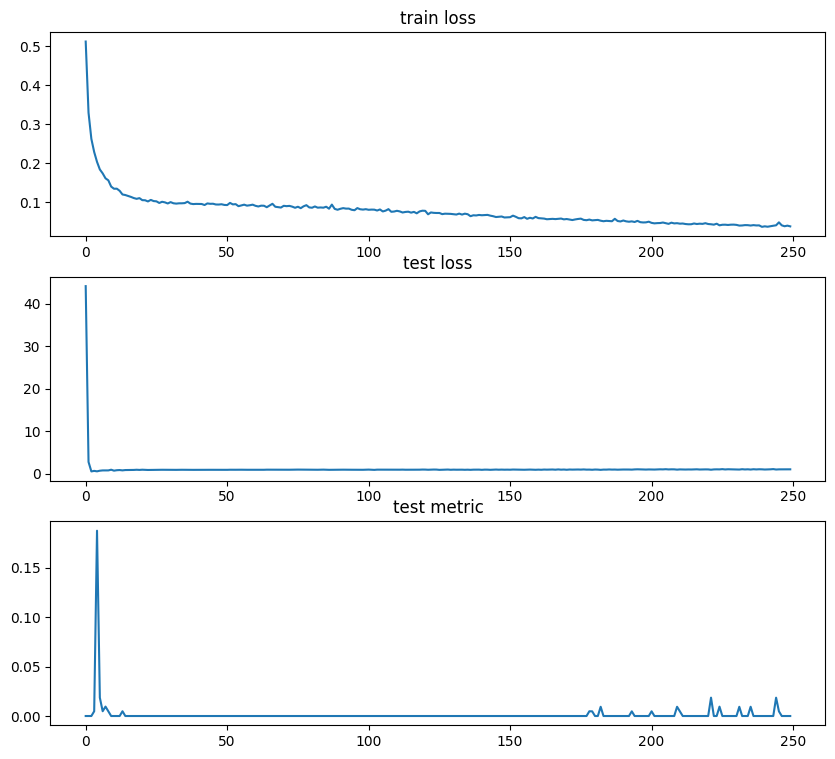

Epoch[250/250] | loss train:0.037707, test:1.005438


100%|███████████████████████████████████████████████████████████████████████| 33/33 [00:02<00:00, 14.46it/s]


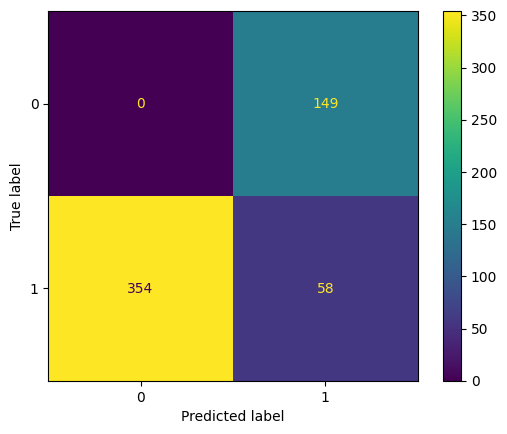

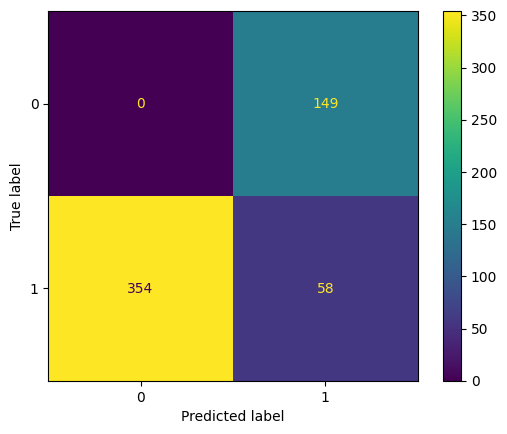

In [31]:
CrossValidationExperement(records, annots, times, all_labels, "./CrossValidationResults/MoscowRecordsNormalizedRightFreqSNEO&MC", 
                          shuffle_leads=False, low_freq=True, is_train=True, area_SWI=True, sneos=all_sneo, mcs=all_mc)

100%|███████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 14.52it/s]


Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/NNSpecialistsData/1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 897999  =      0.000 ...  1795.998 secs...
Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/NNSpecialistsData/-2 marked.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1707999  =      0.000 ...  3415.998 secs...


100%|███████████████████████████████████████████████████████████████████████| 29/29 [00:02<00:00, 14.01it/s]


Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/NNSpecialistsData/-3 marked.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1998999  =      0.000 ...  3997.998 secs...
Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/NNSpecialistsData/patient4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 932499  =      0.000 ...  1864.998 secs...


100%|███████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.99it/s]


Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/NNSpecialistsData/5_marked.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1998999  =      0.000 ...  3997.998 secs...
Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/NNSpecialistsData/DDD.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 312999  =      0.000 ...   625.998 secs...


100%|███████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.89it/s]


Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/NNSpecialistsData/SDA.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 311999  =      0.000 ...   311.999 secs...
Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/NNSpecialistsData/SVV.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 471499  =      0.000 ...   942.998 secs...


100%|███████████████████████████████████████████████████████████████████████| 27/27 [00:02<00:00, 13.46it/s]


Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/NNSpecialistsData/ZSV.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 644999  =      0.000 ...   644.999 secs...
Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/MoscowSpecialistsData/P1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_706650/533507435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  data = mne.io.read_raw_edf("data/" + test_record_names[i])
/tmp/ipykernel_706650/533507435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf("data/" + test_record_names[i])


Reading 0 ... 1551204  =      0.000 ...  7775.352 secs...


/tmp/ipykernel_706650/533507435.py:31: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)
100%|███████████████████████████████████████████████████████████████████████| 56/56 [00:04<00:00, 11.66it/s]


Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/MoscowSpecialistsData/P1_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 14409999  =      0.000 ... 28819.998 secs...
Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/MoscowSpecialistsData/P2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_706650/533507435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  data = mne.io.read_raw_edf("data/" + test_record_names[i])
/tmp/ipykernel_706650/533507435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf("data/" + test_record_names[i])


Reading 0 ... 2875947  =      0.000 ... 14415.576 secs...


/tmp/ipykernel_706650/533507435.py:31: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)
100%|███████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 12.71it/s]


Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/MoscowSpecialistsData/P3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/home/gromov_n/nikolay/lib/python3.10/site-packages/sklearn/metrics/_plot/confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
/tmp/ipykernel_706650/533507435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  data = mne.io.read_raw_edf("data/" + test_record_names[i])


Reading 0 ... 5512100  =      0.000 ... 27629.194 secs...


/tmp/ipykernel_706650/533507435.py:31: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)


Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/MoscowSpecialistsData/P4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_706650/533507435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  data = mne.io.read_raw_edf("data/" + test_record_names[i])
/tmp/ipykernel_706650/533507435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf("data/" + test_record_names[i])


Reading 0 ... 5789904  =      0.000 ... 29021.676 secs...


/tmp/ipykernel_706650/533507435.py:31: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)
100%|███████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.26it/s]


Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/MoscowSpecialistsData/P5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1489315  =      0.000 ...  7465.135 secs...


/tmp/ipykernel_706650/533507435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  data = mne.io.read_raw_edf("data/" + test_record_names[i])
/tmp/ipykernel_706650/533507435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf("data/" + test_record_names[i])
/tmp/ipykernel_706650/533507435.py:31: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)


Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/MoscowSpecialistsData/P6.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6785103  =      0.000 ... 34010.073 secs...


/tmp/ipykernel_706650/533507435.py:31: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)
100%|███████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.39it/s]


Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/MoscowSpecialistsData/P9.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6948681  =      0.000 ... 34830.002 secs...


/tmp/ipykernel_706650/533507435.py:31: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)


Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/MoscowSpecialistsData/P10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_706650/533507435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf("data/" + test_record_names[i])


Reading 0 ... 5043455  =      0.000 ... 25280.128 secs...


/tmp/ipykernel_706650/533507435.py:31: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)
100%|███████████████████████████████████████████████████████████████████████| 33/33 [00:02<00:00, 12.88it/s]


Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/MoscowSpecialistsData/P11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_706650/533507435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  data = mne.io.read_raw_edf("data/" + test_record_names[i])
/tmp/ipykernel_706650/533507435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf("data/" + test_record_names[i])


Reading 0 ... 2155567  =      0.000 ... 10804.698 secs...


/tmp/ipykernel_706650/533507435.py:31: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)


Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/MoscowSpecialistsData/P12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 136115  =      0.000 ...   682.271 secs...


/tmp/ipykernel_706650/533507435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  data = mne.io.read_raw_edf("data/" + test_record_names[i])
/tmp/ipykernel_706650/533507435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf("data/" + test_record_names[i])
/tmp/ipykernel_706650/533507435.py:31: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)


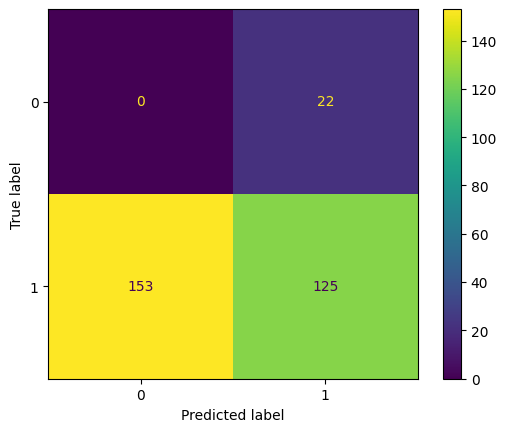

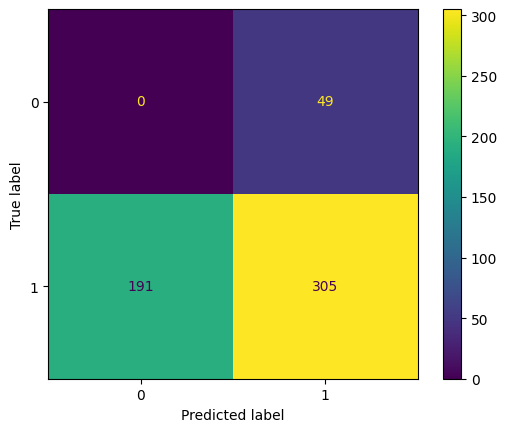

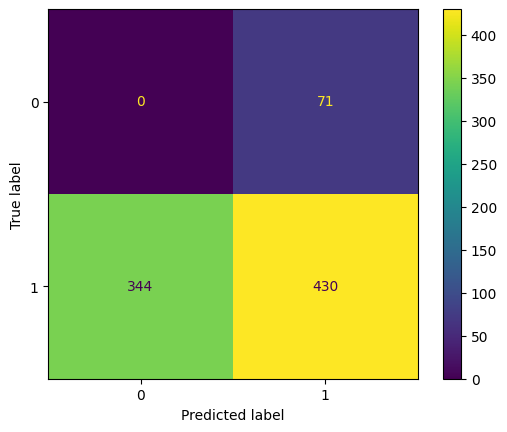

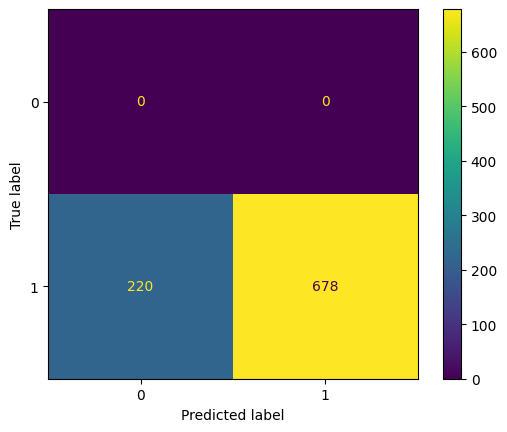

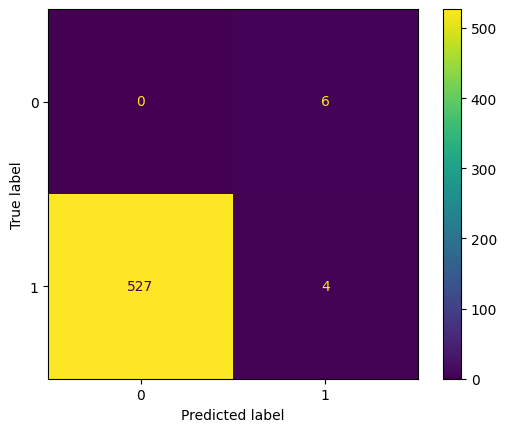

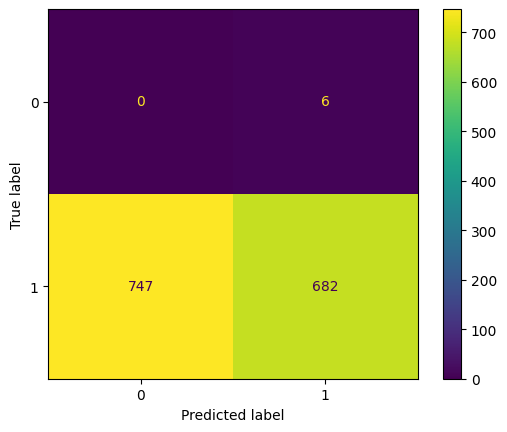

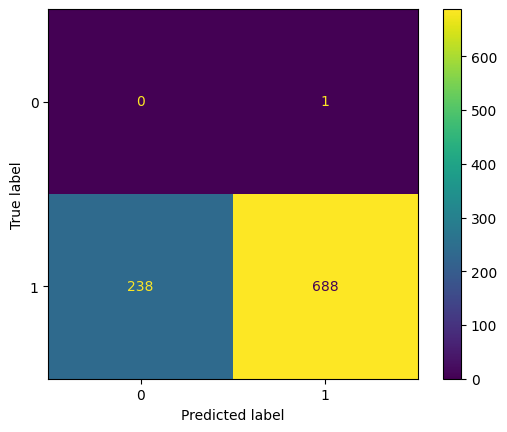

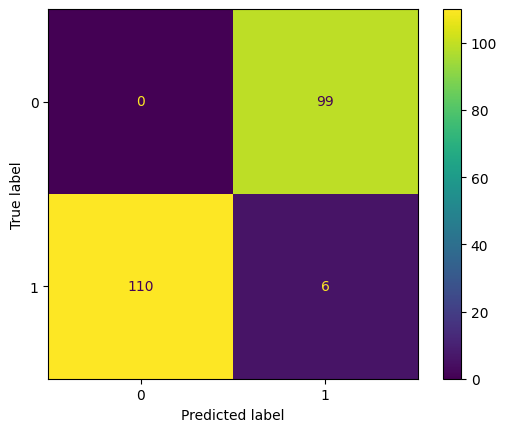

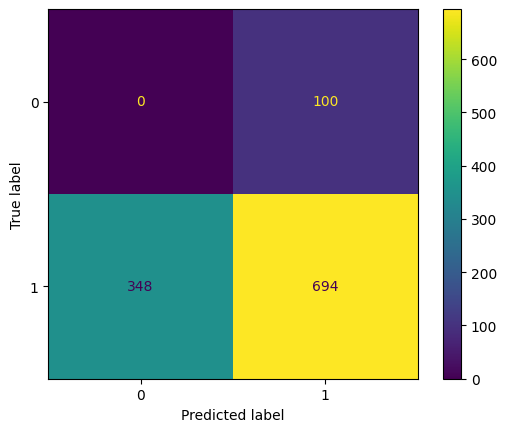

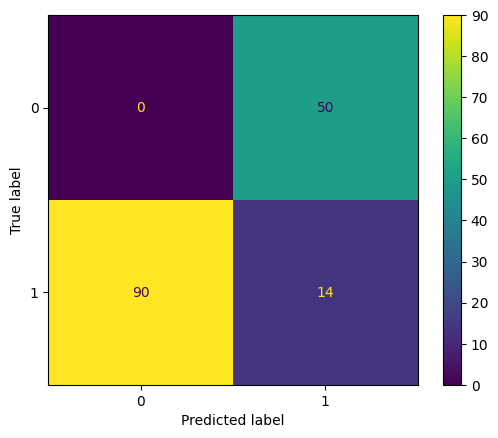

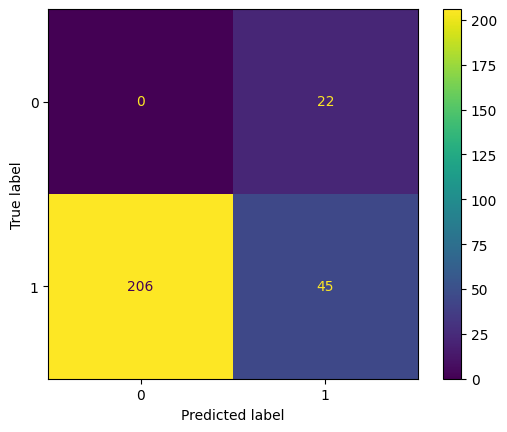

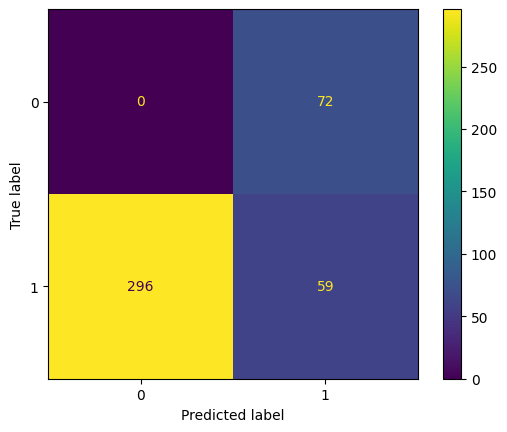

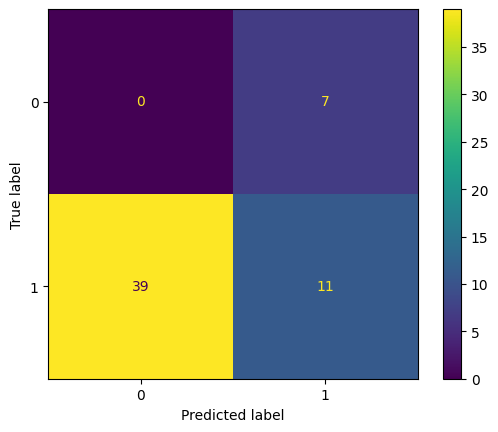

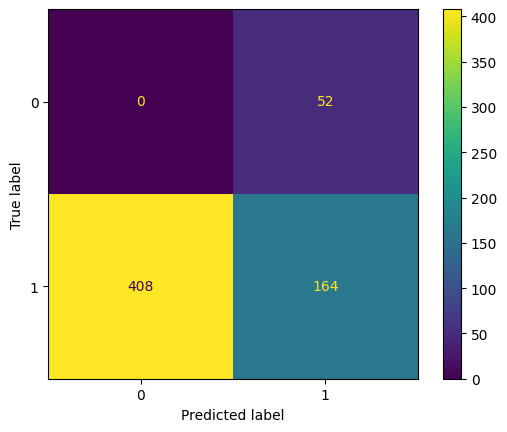

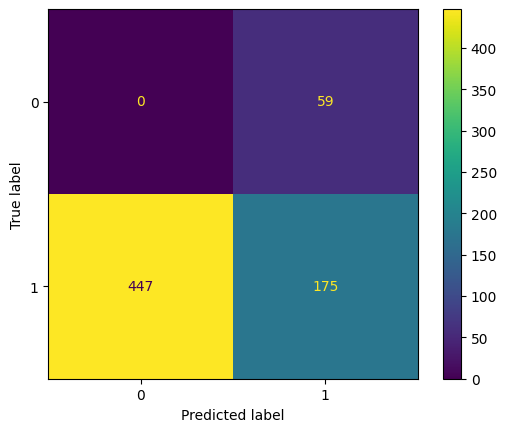

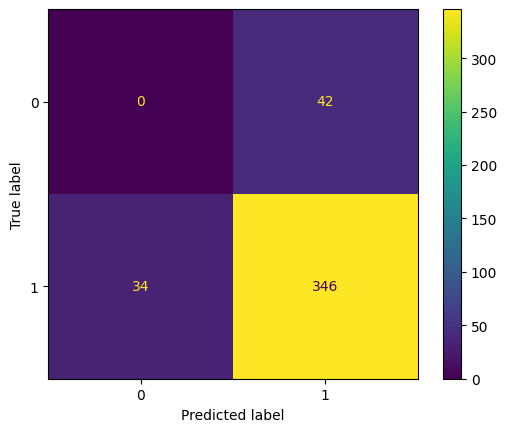

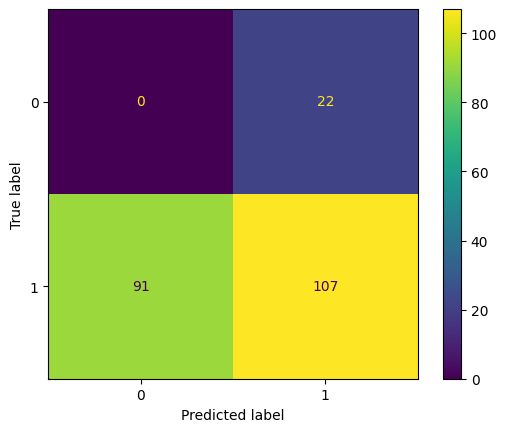

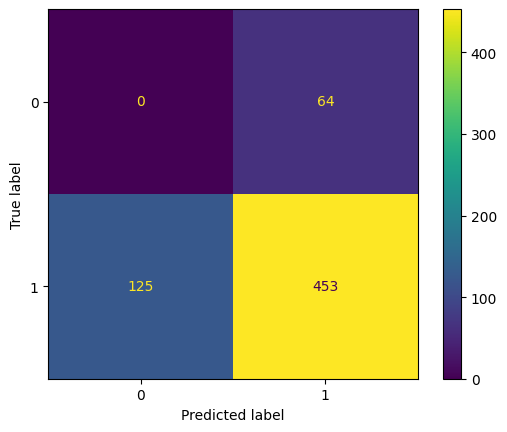

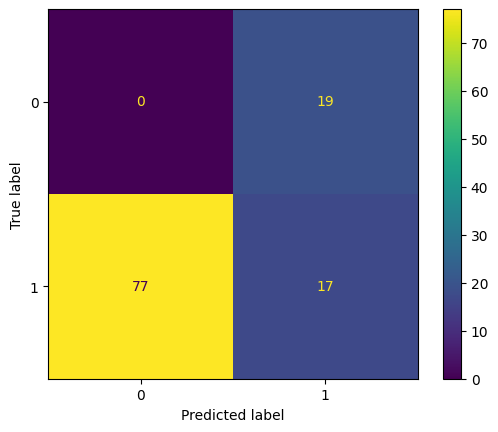

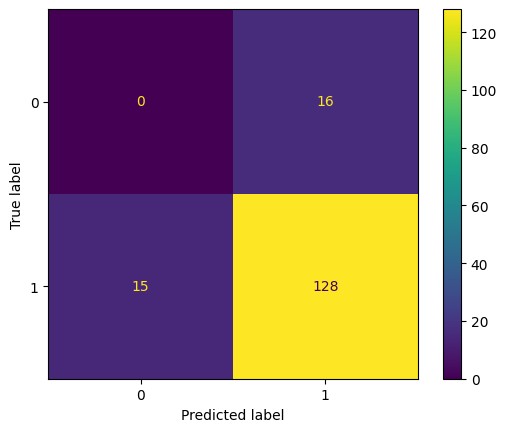

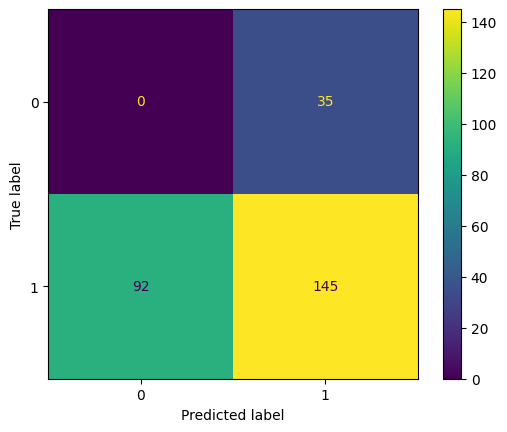

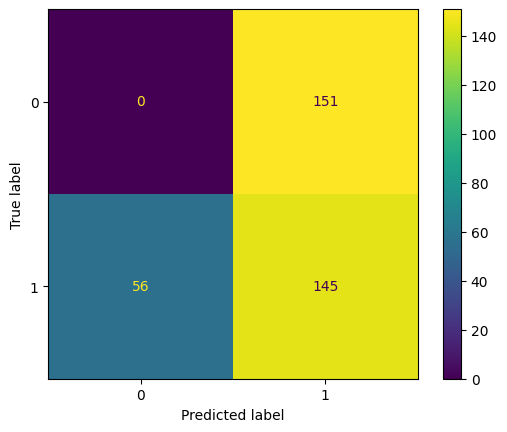

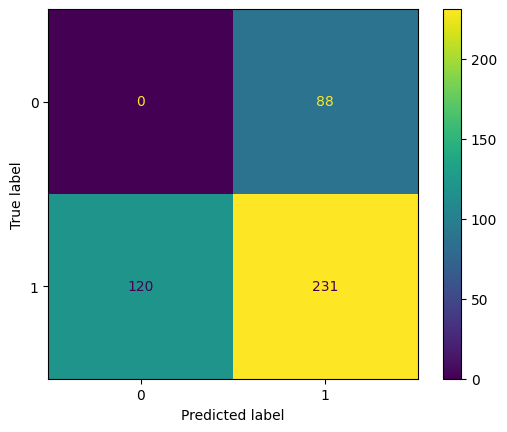

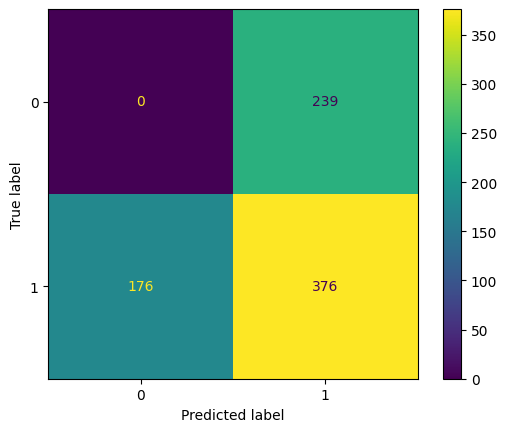

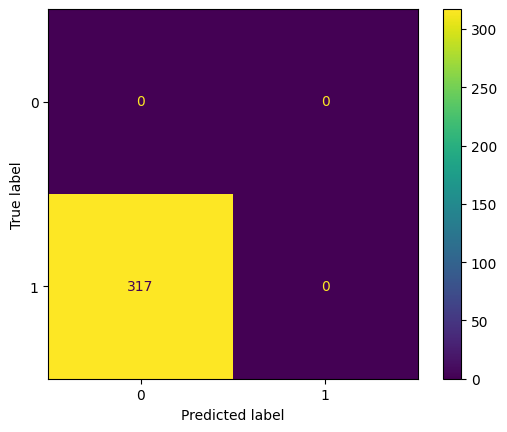

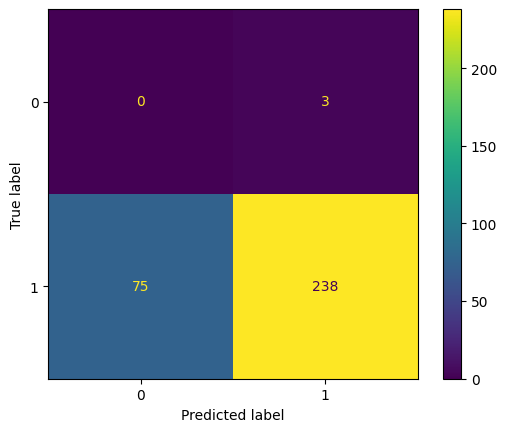

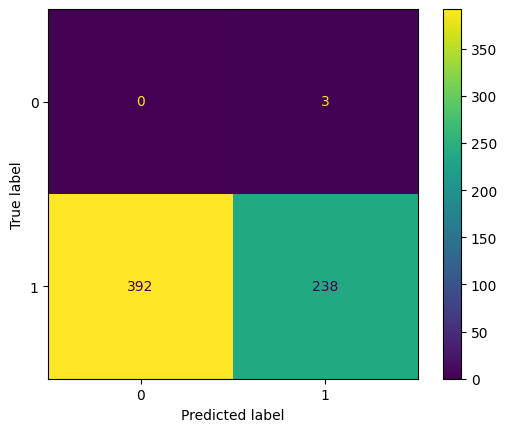

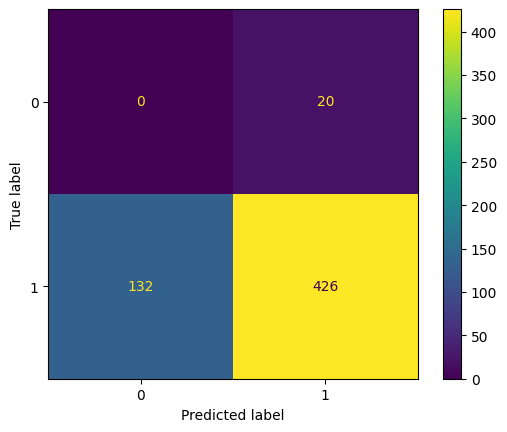

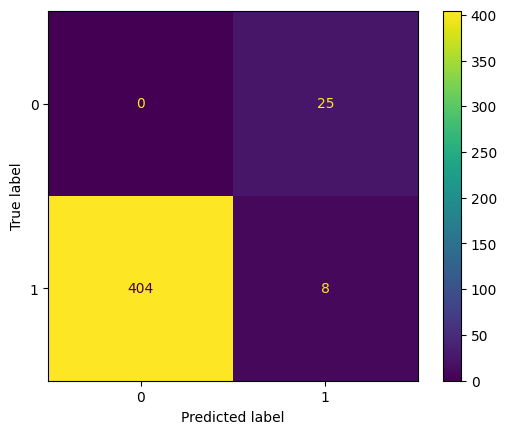

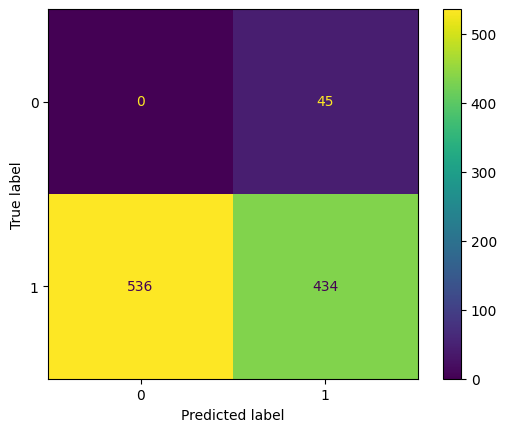

In [36]:
CrossValidationExperement(records, annots, times, all_labels, "./CrossValidationResults/20RecordsNormalizedRightFreqSNEO&MC", 
                          shuffle_leads=False, low_freq=True, is_train=False, write_edf=True, area_SWI=True, sneos=all_sneo, mcs=all_mc)

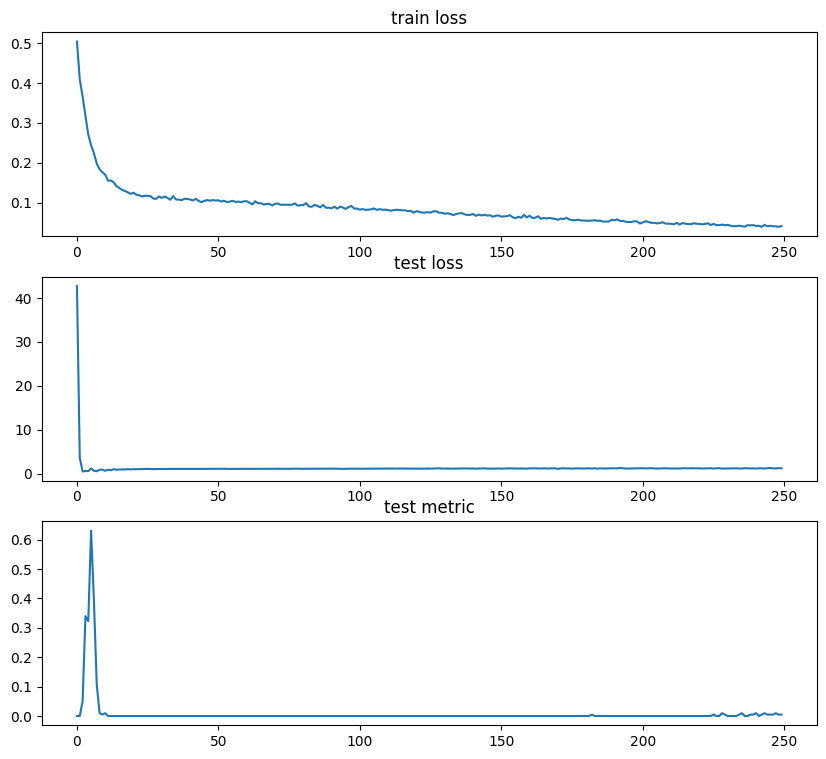

Epoch[250/250] | loss train:0.041364, test:1.205871


100%|█████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 16.81it/s]


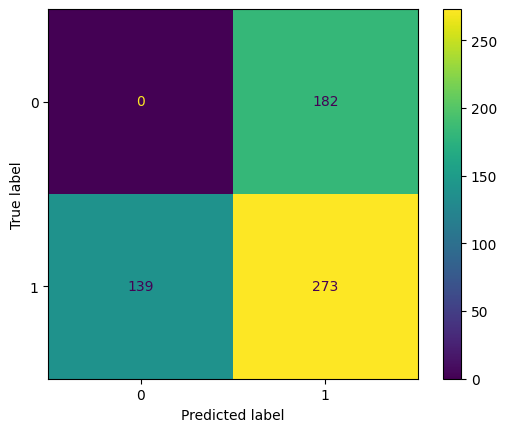

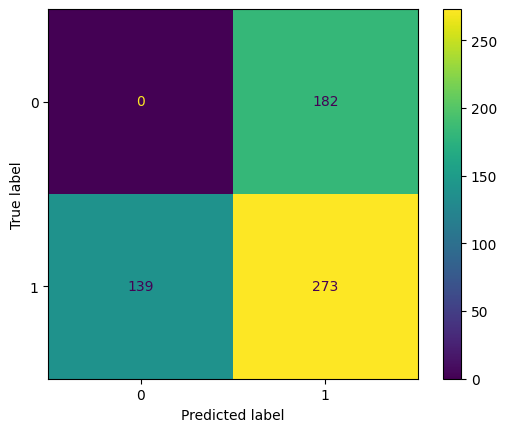

In [29]:
CrossValidationExperement(records, annots, times, all_labels, "./CrossValidationResults/20RecordsNormalizedRightFreqOnlyMoscow", 
                          shuffle_leads=False, low_freq=True, is_train=True, area_SWI=True)

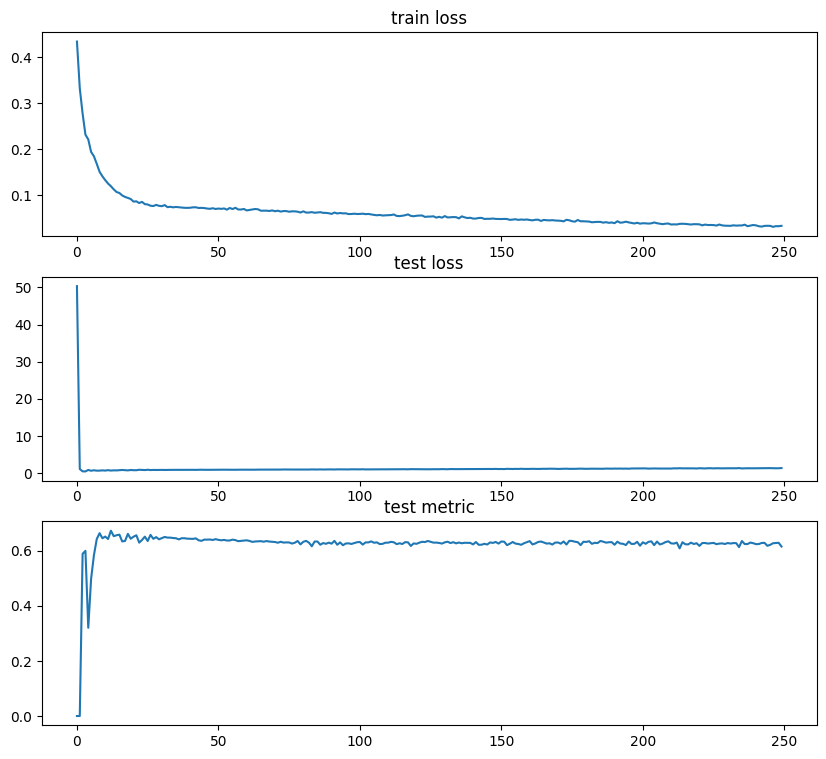

Epoch[250/250] | loss train:0.033902, test:1.411242


100%|█████████████████████████████████████████████████████████████████████| 33/33 [00:02<00:00, 16.30it/s]


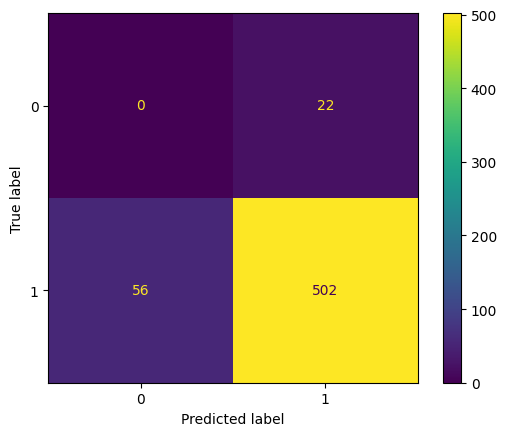

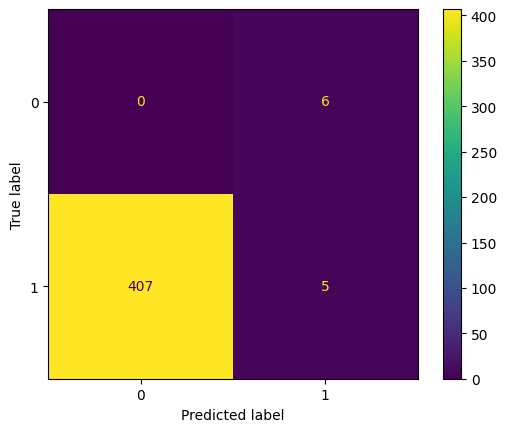

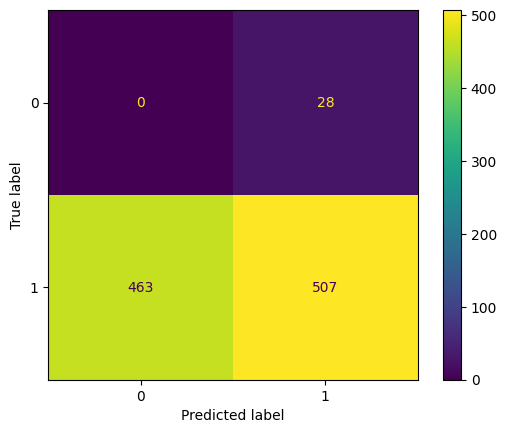

In [41]:
CrossValidationExperement(records, annots, times, all_labels, "./CrossValidationResults/20RecordsNormalizedRightFreq", 
                          shuffle_leads=False, low_freq=True, is_train=True, area_SWI=True)

100%|███████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 16.54it/s]


Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/NNSpecialistsData/1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Overwriting existing file.
Reading 0 ... 897999  =      0.000 ...  1795.998 secs...
Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/NNSpecialistsData/-2 marked.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Overwriting existing file.
Reading 0 ... 1707999  =      0.000 ...  3415.998 secs...


100%|███████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 16.68it/s]


Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/NNSpecialistsData/-3 marked.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Overwriting existing file.
Reading 0 ... 1998999  =      0.000 ...  3997.998 secs...
Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/NNSpecialistsData/patient4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Overwriting existing file.
Reading 0 ... 932499  =      0.000 ...  1864.998 secs...


100%|███████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 15.85it/s]


Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/NNSpecialistsData/5_marked.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Overwriting existing file.
Reading 0 ... 1998999  =      0.000 ...  3997.998 secs...
Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/NNSpecialistsData/DDD.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Overwriting existing file.
Reading 0 ... 312999  =      0.000 ...   625.998 secs...


100%|███████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 16.01it/s]


Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/NNSpecialistsData/SDA.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Overwriting existing file.
Reading 0 ... 311999  =      0.000 ...   311.999 secs...
Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/NNSpecialistsData/SVV.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Overwriting existing file.
Reading 0 ... 471499  =      0.000 ...   942.998 secs...


100%|███████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 16.42it/s]


Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/NNSpecialistsData/ZSV.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Overwriting existing file.
Reading 0 ... 644999  =      0.000 ...   644.999 secs...
Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/MoscowSpecialistsData/P1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_706650/533507435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  data = mne.io.read_raw_edf("data/" + test_record_names[i])
/tmp/ipykernel_706650/533507435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf("data/" + test_record_names[i])


Overwriting existing file.
Reading 0 ... 1551204  =      0.000 ...  7775.352 secs...


/tmp/ipykernel_706650/533507435.py:31: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)
100%|███████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 16.29it/s]


Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/MoscowSpecialistsData/P1_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 14409999  =      0.000 ... 28819.998 secs...
Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/MoscowSpecialistsData/P2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_706650/533507435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  data = mne.io.read_raw_edf("data/" + test_record_names[i])
/tmp/ipykernel_706650/533507435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf("data/" + test_record_names[i])


Reading 0 ... 2875947  =      0.000 ... 14415.576 secs...


/tmp/ipykernel_706650/533507435.py:31: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)
100%|███████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.57it/s]


Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/MoscowSpecialistsData/P3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/home/gromov_n/nikolay/lib/python3.10/site-packages/sklearn/metrics/_plot/confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
/tmp/ipykernel_706650/533507435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  data = mne.io.read_raw_edf("data/" + test_record_names[i])


Reading 0 ... 5512100  =      0.000 ... 27629.194 secs...


/tmp/ipykernel_706650/533507435.py:31: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)


Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/MoscowSpecialistsData/P4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_706650/533507435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  data = mne.io.read_raw_edf("data/" + test_record_names[i])
/tmp/ipykernel_706650/533507435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf("data/" + test_record_names[i])


Reading 0 ... 5789904  =      0.000 ... 29021.676 secs...


/tmp/ipykernel_706650/533507435.py:31: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)
100%|███████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.73it/s]


Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/MoscowSpecialistsData/P5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1489315  =      0.000 ...  7465.135 secs...


/tmp/ipykernel_706650/533507435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  data = mne.io.read_raw_edf("data/" + test_record_names[i])
/tmp/ipykernel_706650/533507435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf("data/" + test_record_names[i])
/tmp/ipykernel_706650/533507435.py:31: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)


Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/MoscowSpecialistsData/P6.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6785103  =      0.000 ... 34010.073 secs...


/tmp/ipykernel_706650/533507435.py:31: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)
100%|███████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 16.99it/s]


Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/MoscowSpecialistsData/P9.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6948681  =      0.000 ... 34830.002 secs...


/tmp/ipykernel_706650/533507435.py:31: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)


Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/MoscowSpecialistsData/P10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_706650/533507435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf("data/" + test_record_names[i])


Reading 0 ... 5043455  =      0.000 ... 25280.128 secs...


/tmp/ipykernel_706650/533507435.py:31: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)
100%|███████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 16.90it/s]


Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/MoscowSpecialistsData/P11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2155567  =      0.000 ... 10804.698 secs...


/tmp/ipykernel_706650/533507435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  data = mne.io.read_raw_edf("data/" + test_record_names[i])
/tmp/ipykernel_706650/533507435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf("data/" + test_record_names[i])
/tmp/ipykernel_706650/533507435.py:31: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)


Extracting EDF parameters from /mnt/hdd-home/gromov_n/extreme-events/EEG seizure/EpiActivity/data/MoscowSpecialistsData/P12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 136115  =      0.000 ...   682.271 secs...


/tmp/ipykernel_706650/533507435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  data = mne.io.read_raw_edf("data/" + test_record_names[i])
/tmp/ipykernel_706650/533507435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf("data/" + test_record_names[i])
/tmp/ipykernel_706650/533507435.py:31: RuntimeWarning: Data has a non-integer sampling rate of 199.50274692224406; writing to EDF format may cause a small change to sample times.
  data.export(path + "/Split" + str(split_index) + "/Preds_" + test_record_names[i].split("/")[1], overwrite=True)


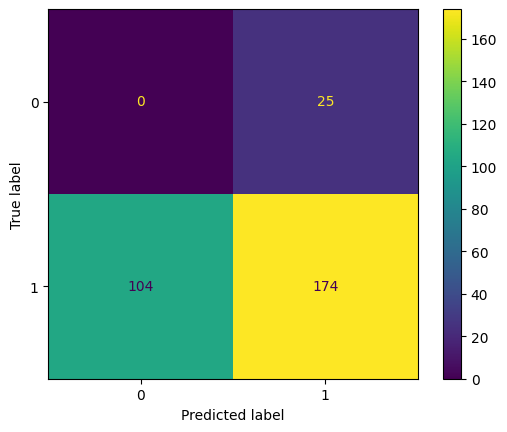

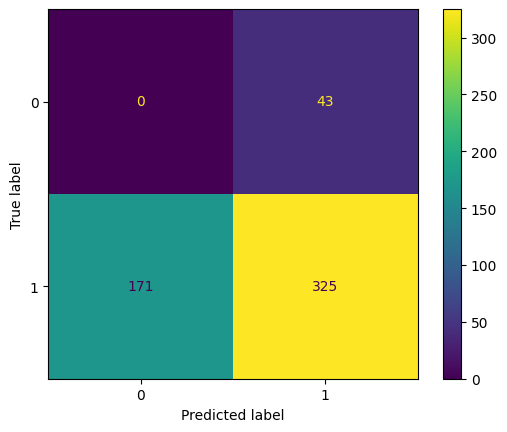

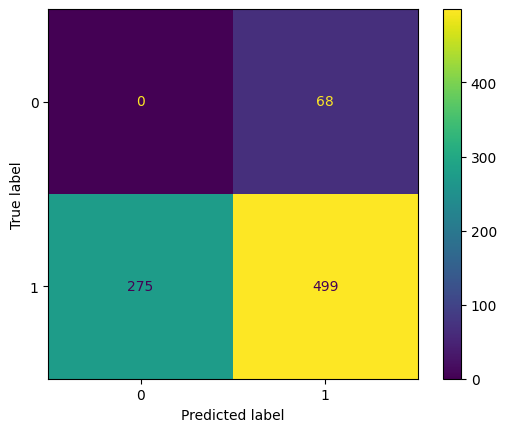

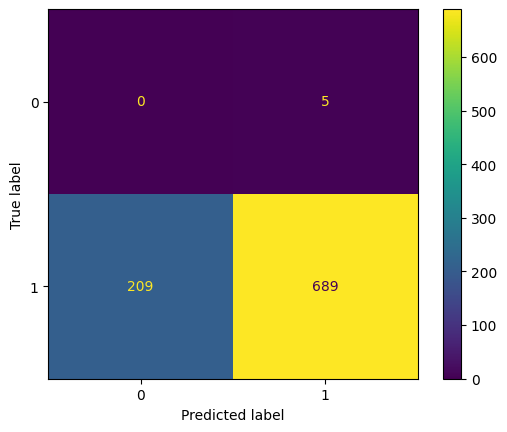

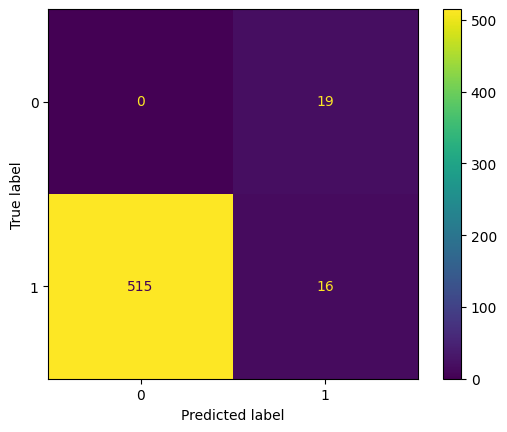

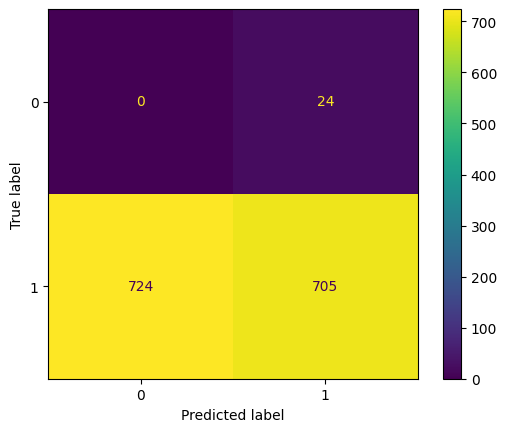

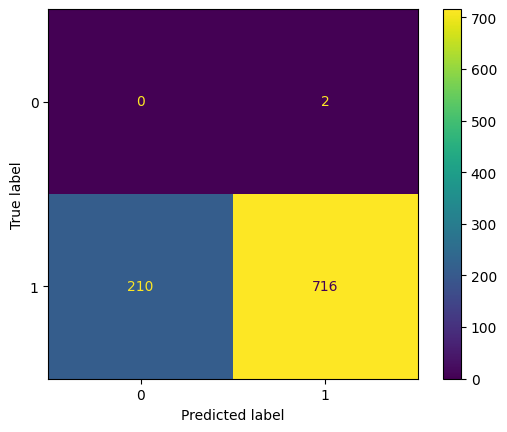

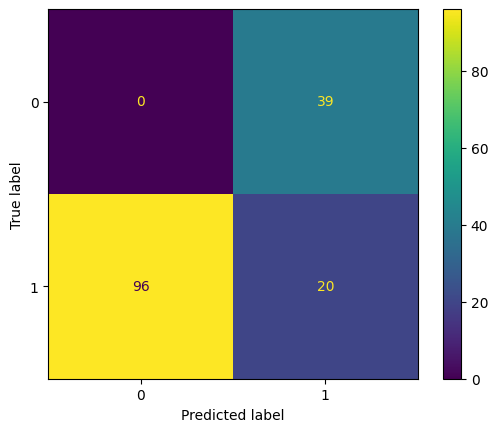

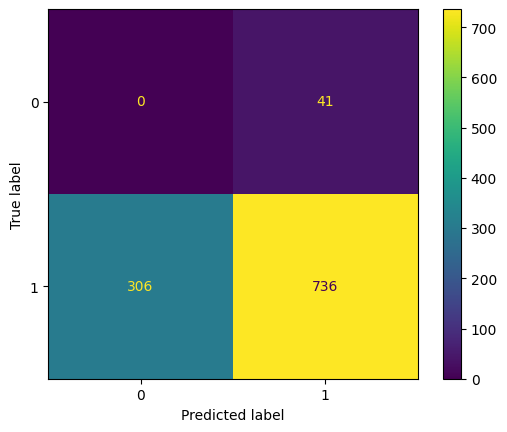

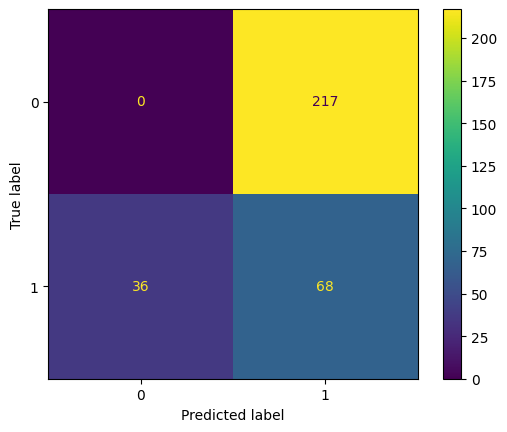

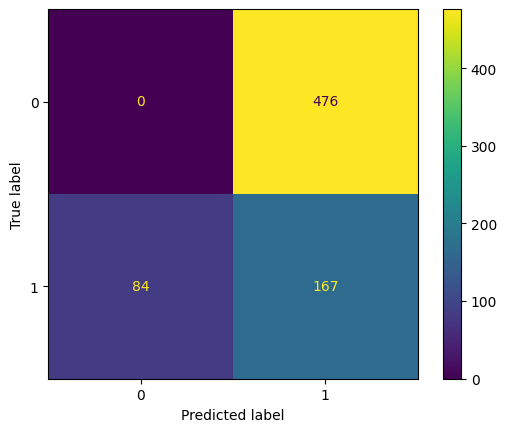

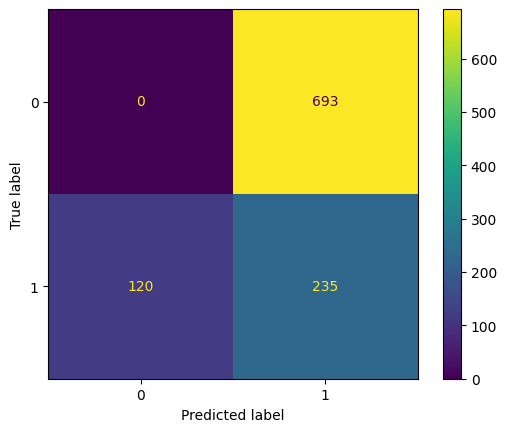

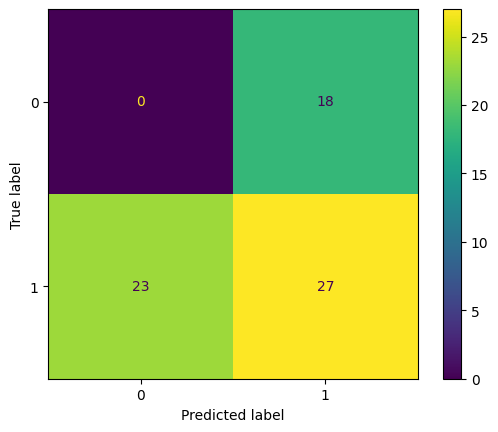

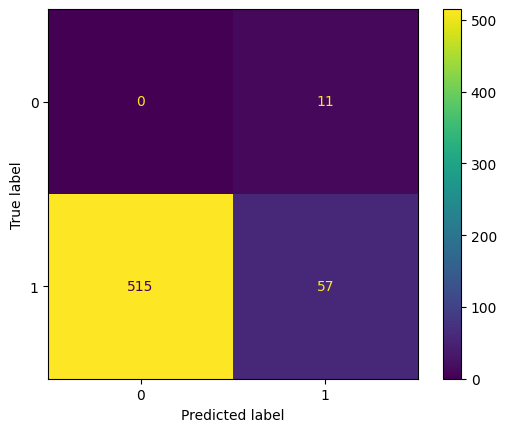

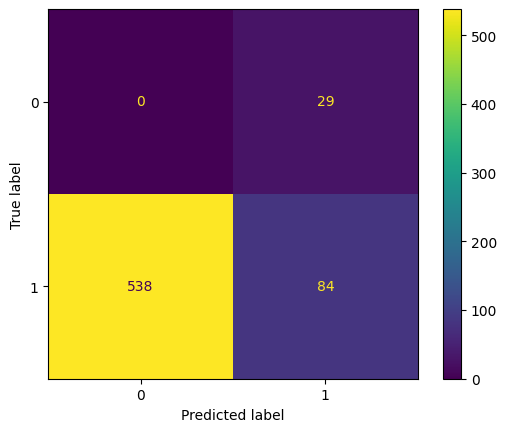

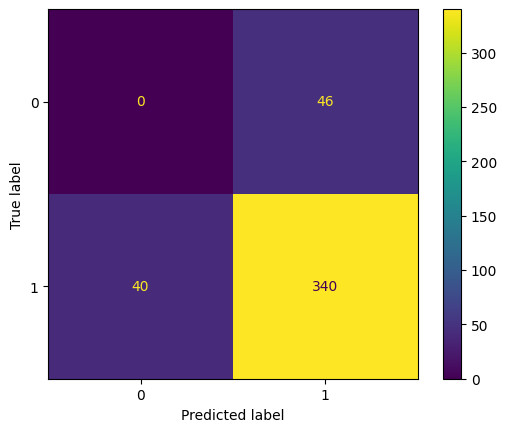

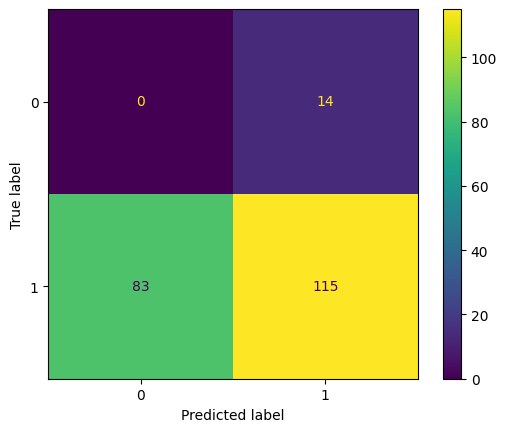

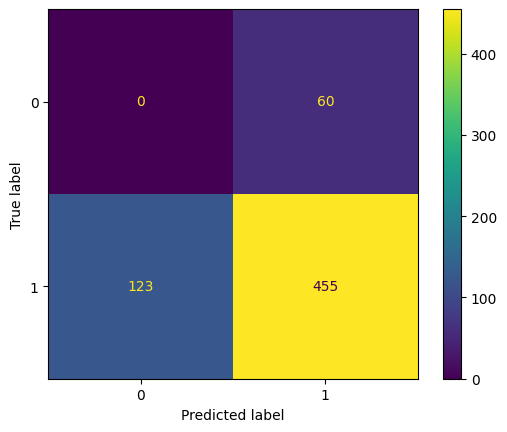

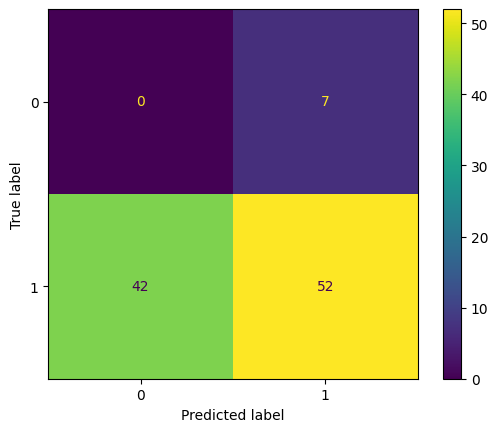

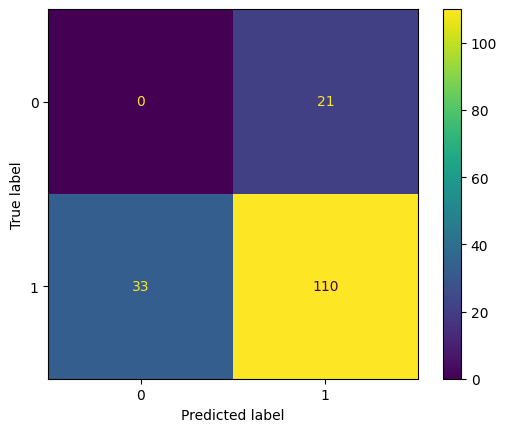

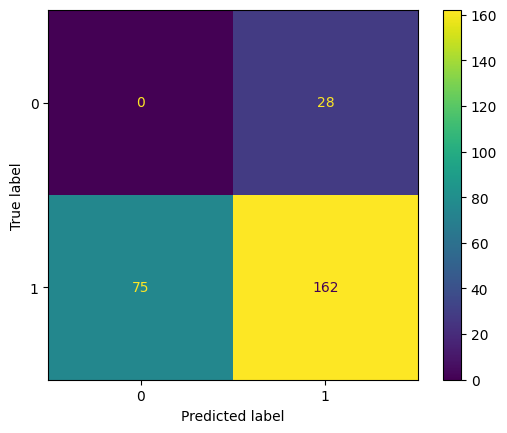

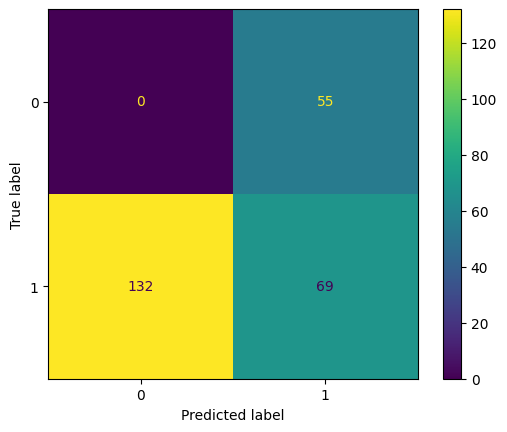

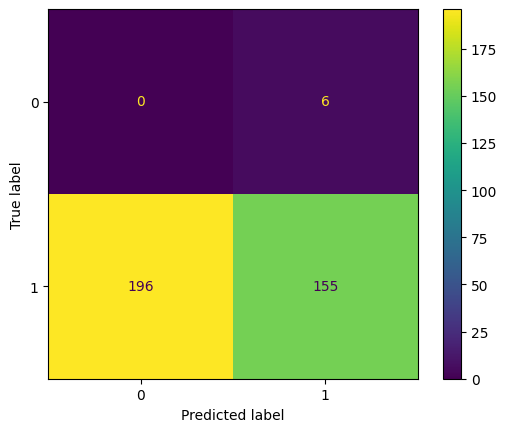

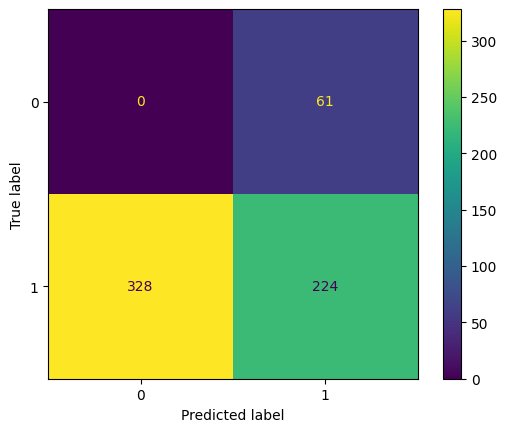

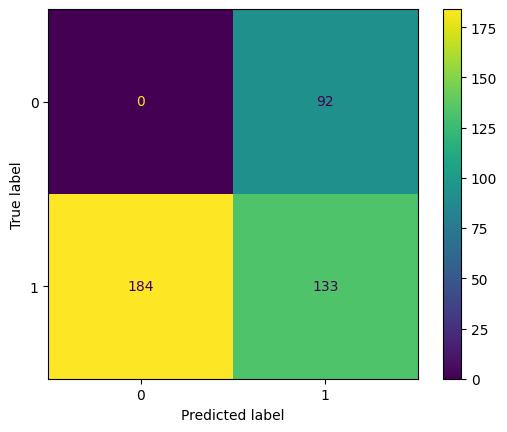

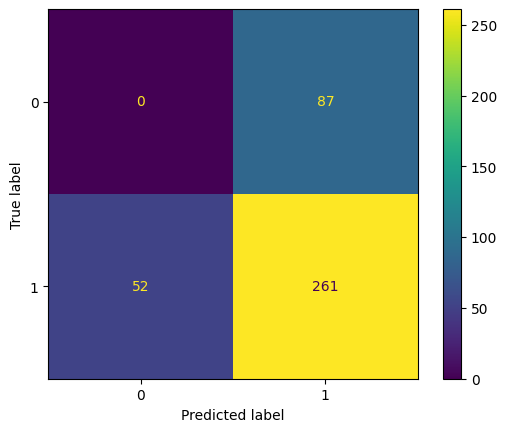

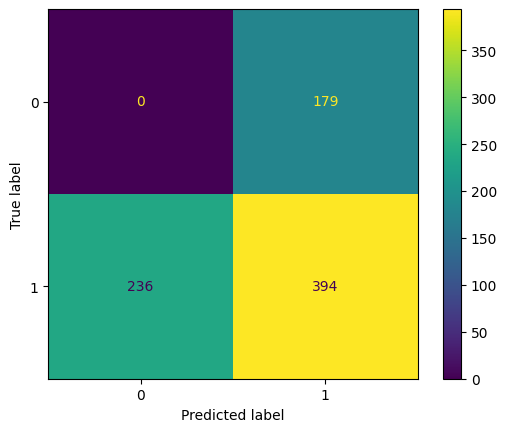

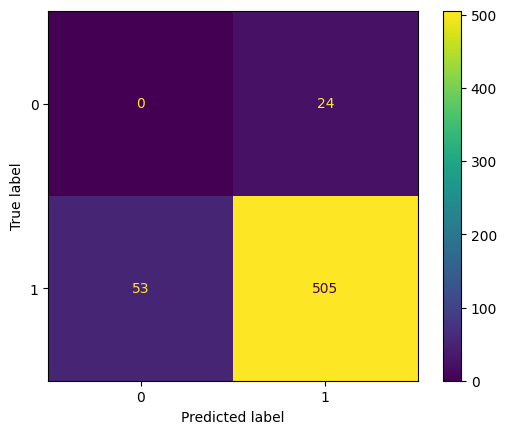

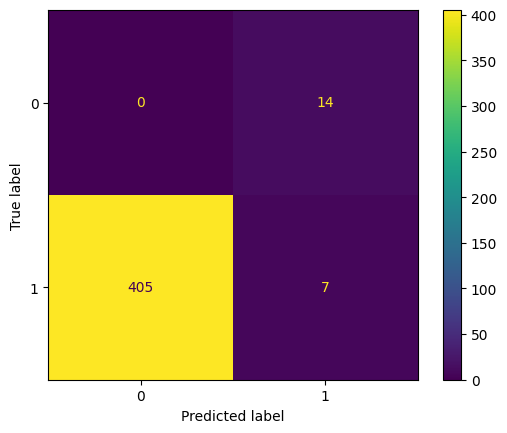

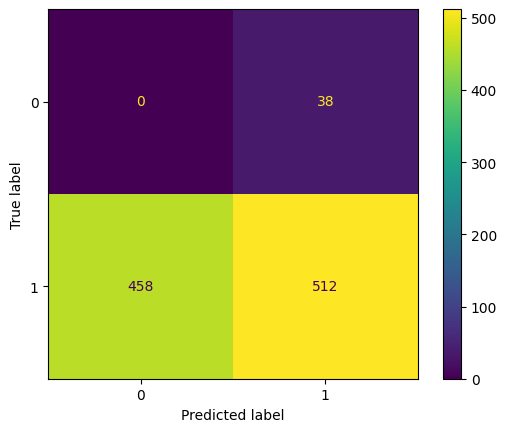

In [49]:
CrossValidationExperement(records, annots, times, all_labels, "./CrossValidationResults/20RecordsNormalized", 
                          shuffle_leads=False, low_freq=True, write_edf=True, is_train=False, area_SWI=True)

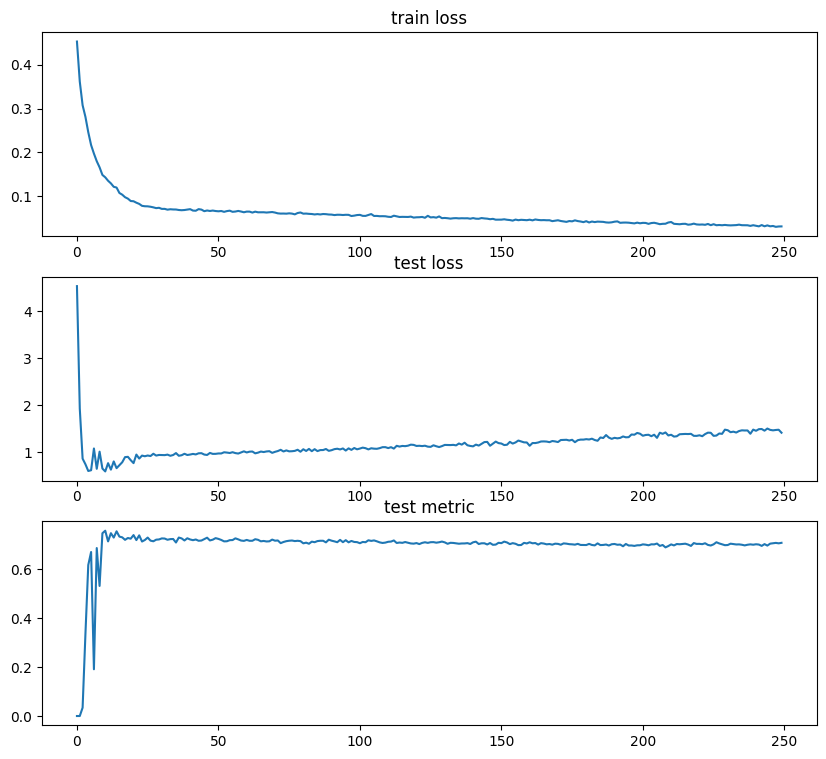

Epoch[250/250] | loss train:0.031371, test:1.415915


100%|█████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 16.63it/s]


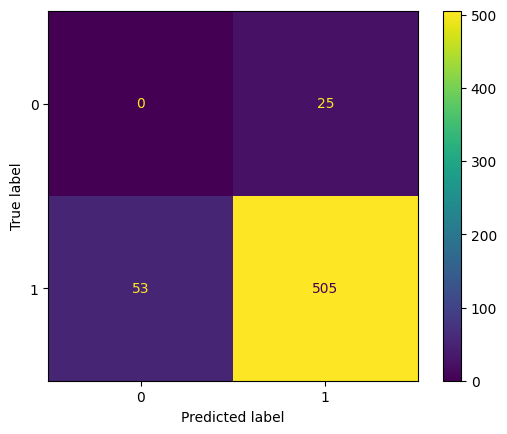

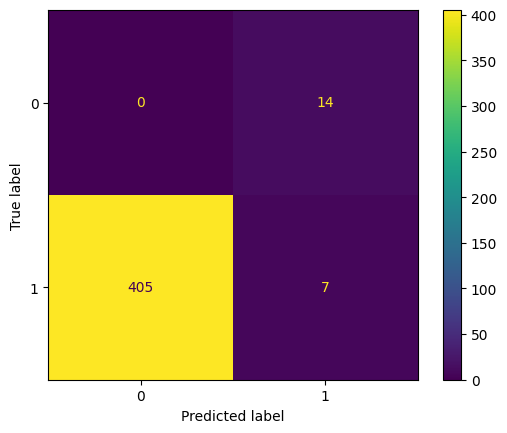

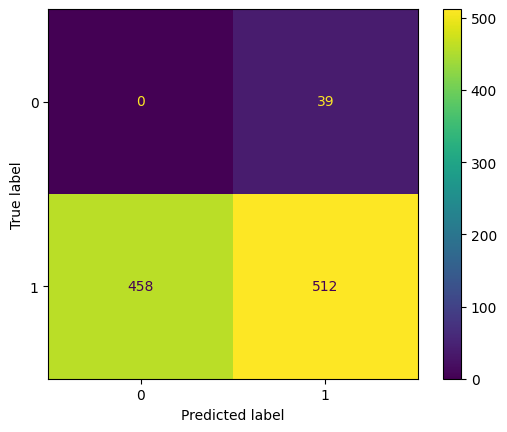

In [28]:
CrossValidationExperement(records, annots, times, all_labels, "./CrossValidationResults/20RecordsNormalized", 
                          shuffle_leads=False, low_freq=True, is_train=True, area_SWI=True)

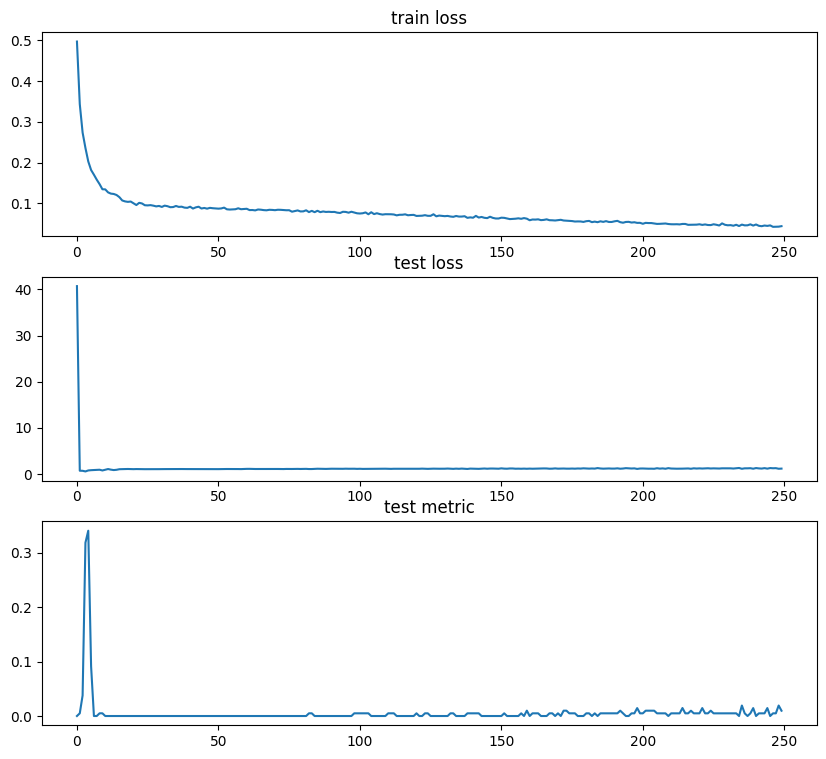

Epoch[250/250] | loss train:0.044049, test:1.193146


100%|██████████████████████████████████████████████████████| 33/33 [00:01<00:00, 16.72it/s]


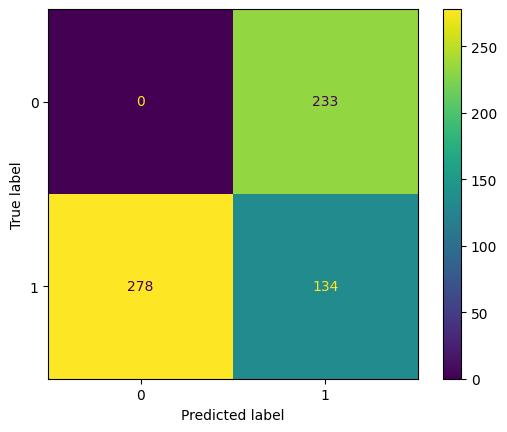

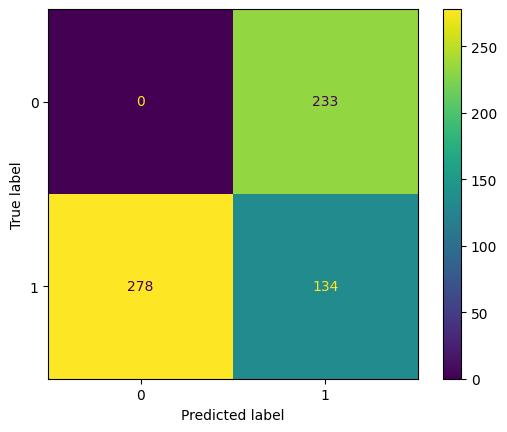

In [48]:
CrossValidationExperement(records, annots, times, all_labels, "./CrossValidationResults/13RecordsNormalized", 
                          shuffle_leads=False, low_freq=True, is_train=True, area_SWI=True)

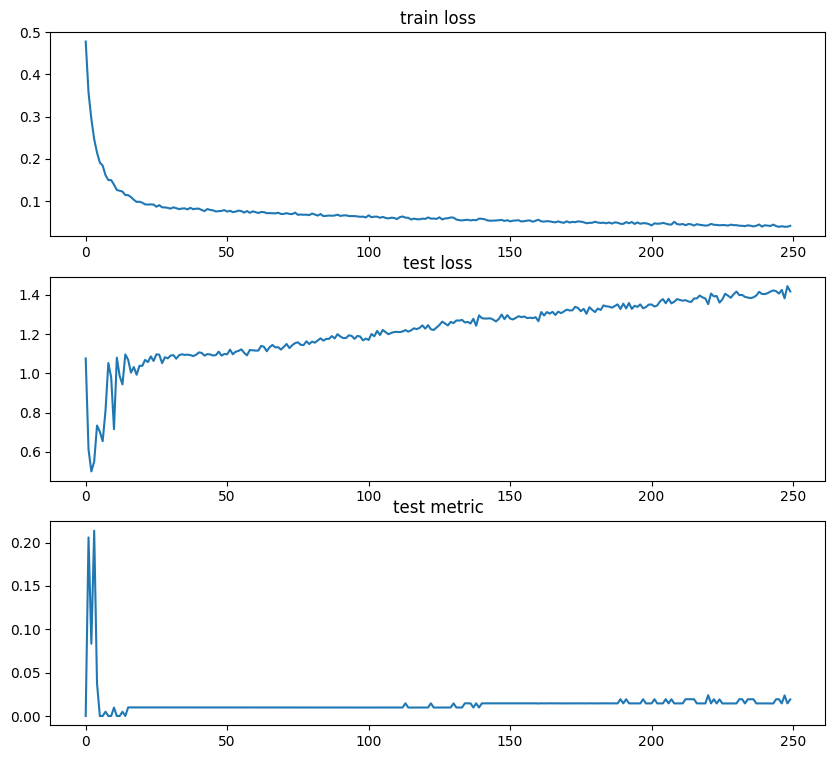

Epoch[250/250] | loss train:0.041561, test:1.416289


100%|██████████████████████████████████████████████████████| 33/33 [00:01<00:00, 17.11it/s]


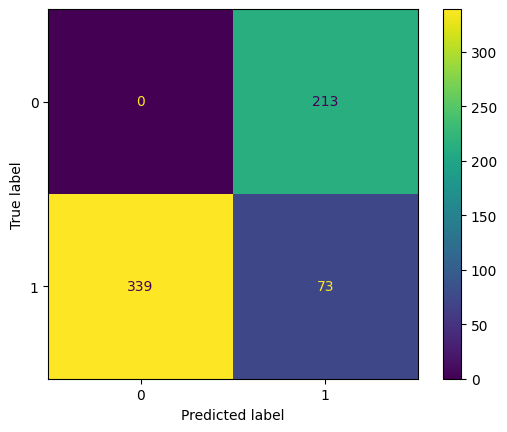

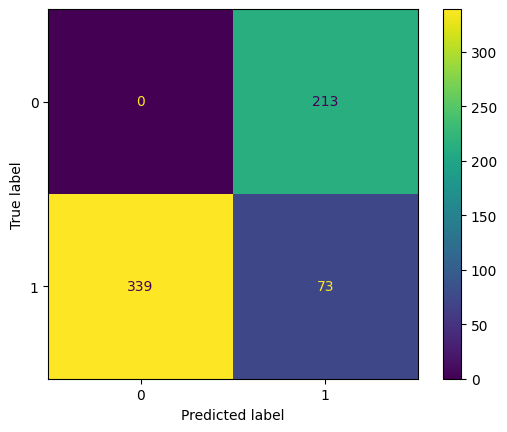

In [45]:
CrossValidationExperement(records, annots, times, all_labels, "./CrossValidationResults/13Records", 
                          shuffle_leads=False, low_freq=True, is_train=True, area_SWI=True)

100%|███████████████████████████████████████████████████████████████| 35/35 [00:02<00:00, 16.37it/s]


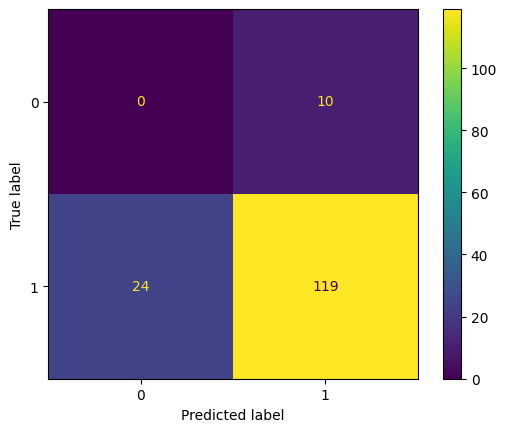

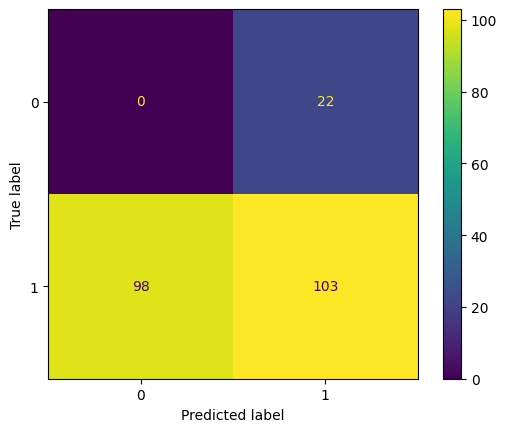

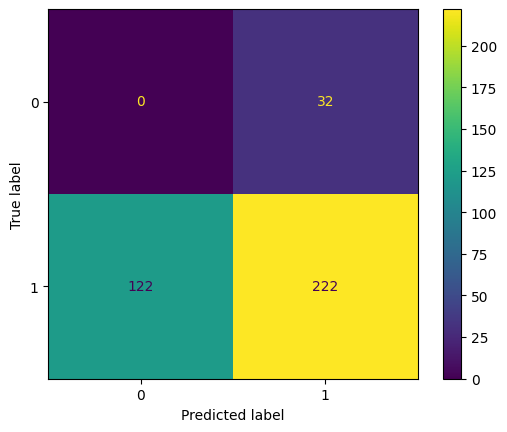

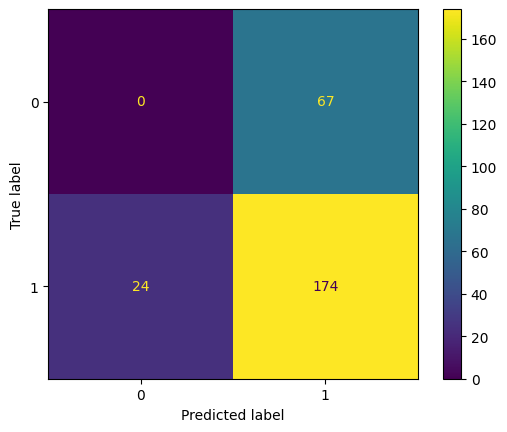

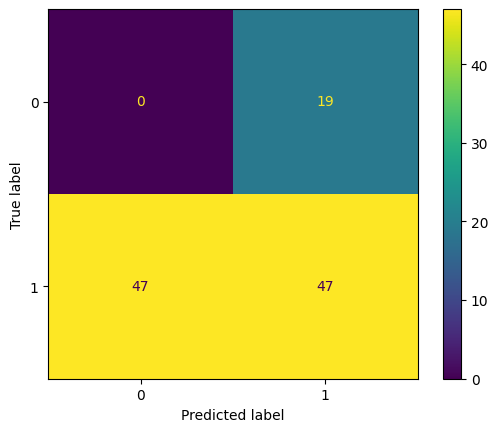

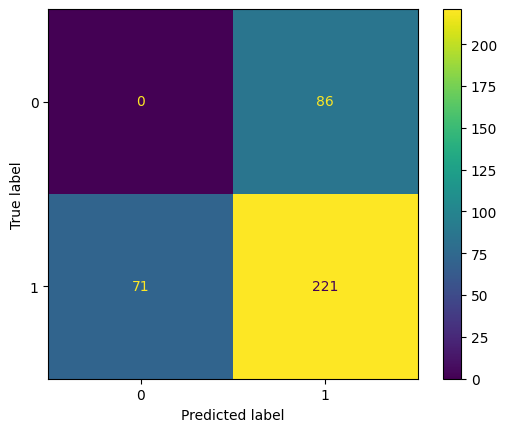

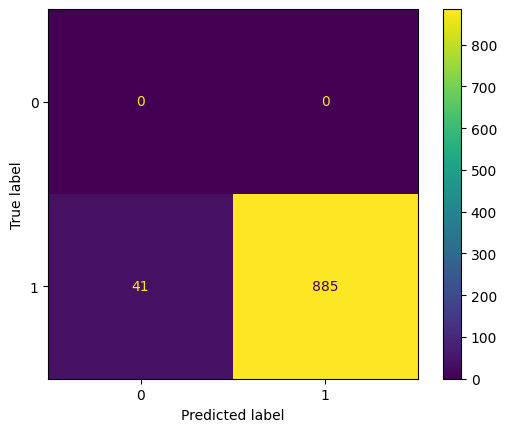

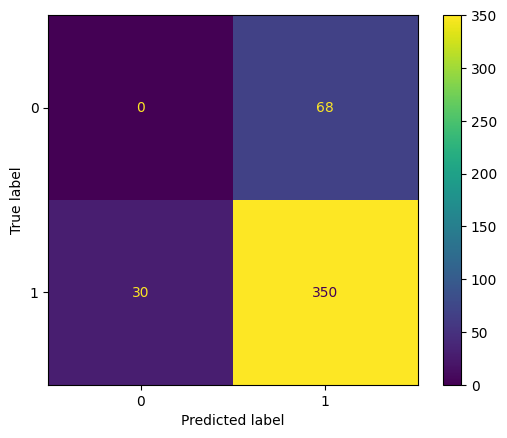

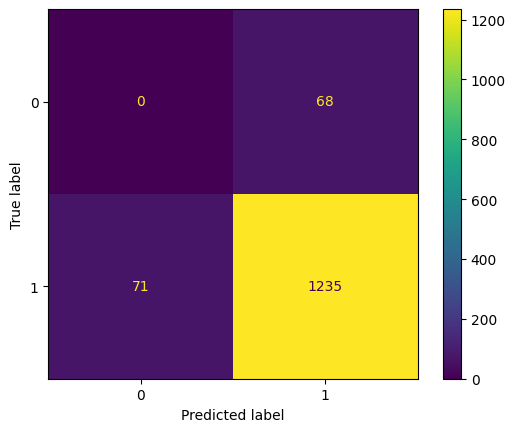

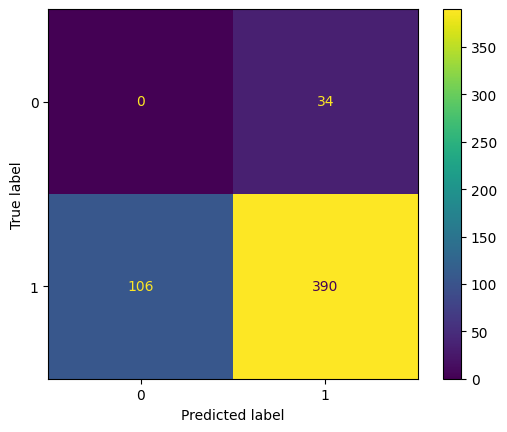

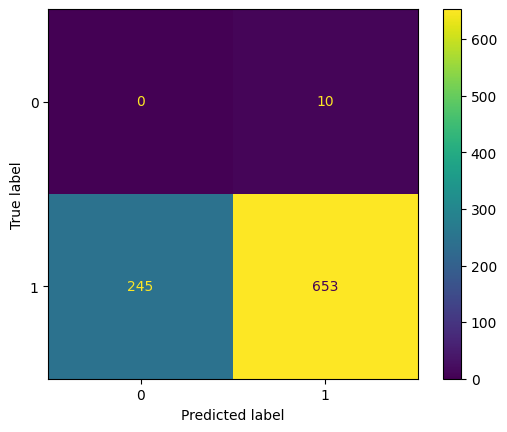

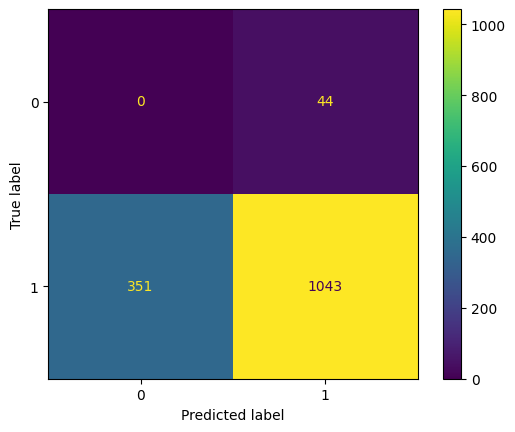

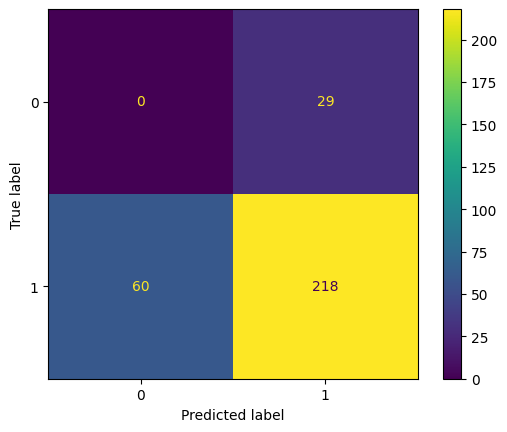

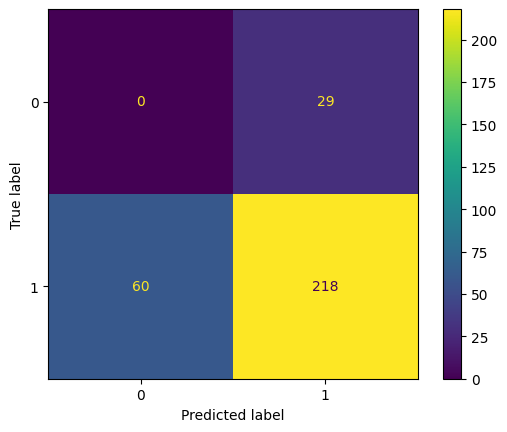

In [30]:
CrossValidationExperement(records, annots, times, all_labels, "./CrossValidationResults/NewSWI", 
                          shuffle_leads=False, low_freq=True, is_train=False, area_SWI=True)

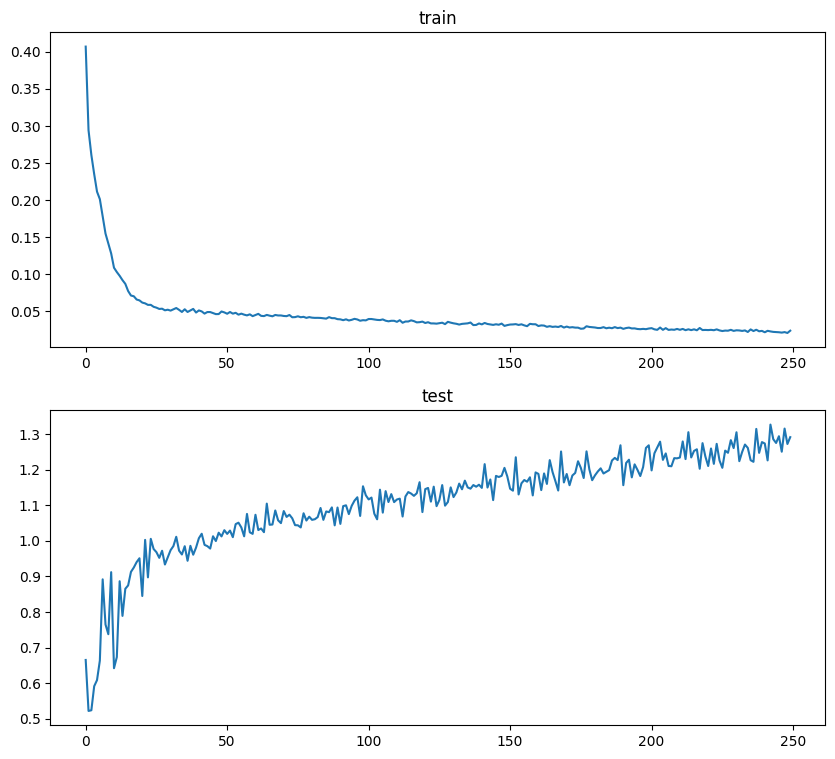

Epoch[250/250] | loss train:0.024067, test:1.291402


100%|███████████████████████████████████████████████████████████████| 74/74 [00:04<00:00, 16.45it/s]


ZeroDivisionError: division by zero

In [25]:
CrossValidationExperement(records, annots, times, all_labels, "./CrossValidationResults/Freq500MixedLeads", 
                          shuffle_leads=True, low_freq=False)

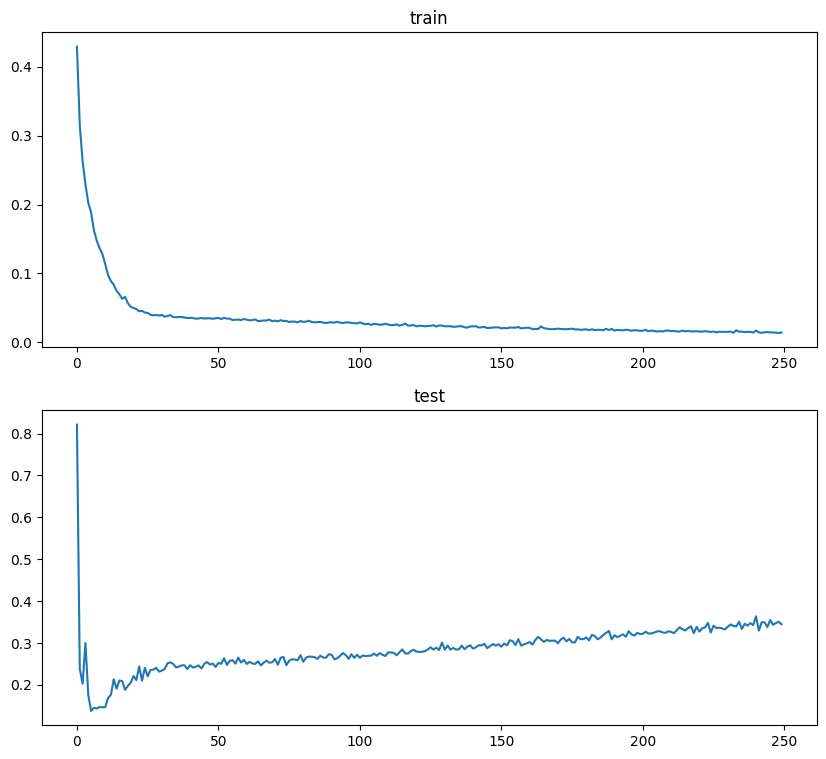

Epoch[250/250] | loss train:0.014315, test:0.344864


100%|███████████████████████████████████████████| 88/88 [00:05<00:00, 17.28it/s]


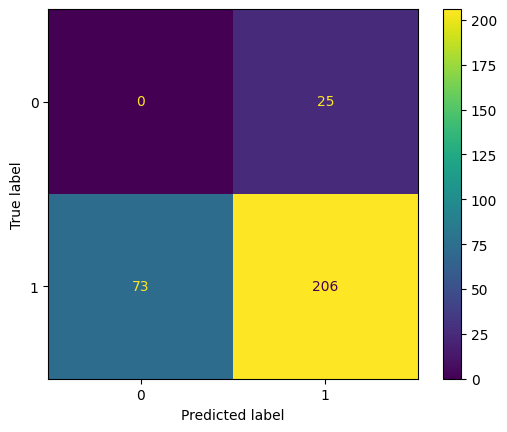

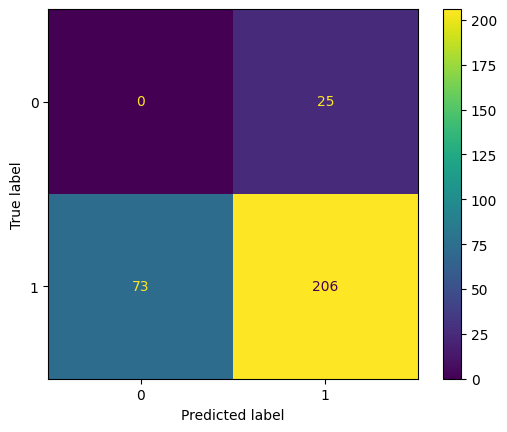

In [76]:
CrossValidationExperement(records, annots, times, all_labels, "./CrossValidationResults/Freq500", low_freq=False)

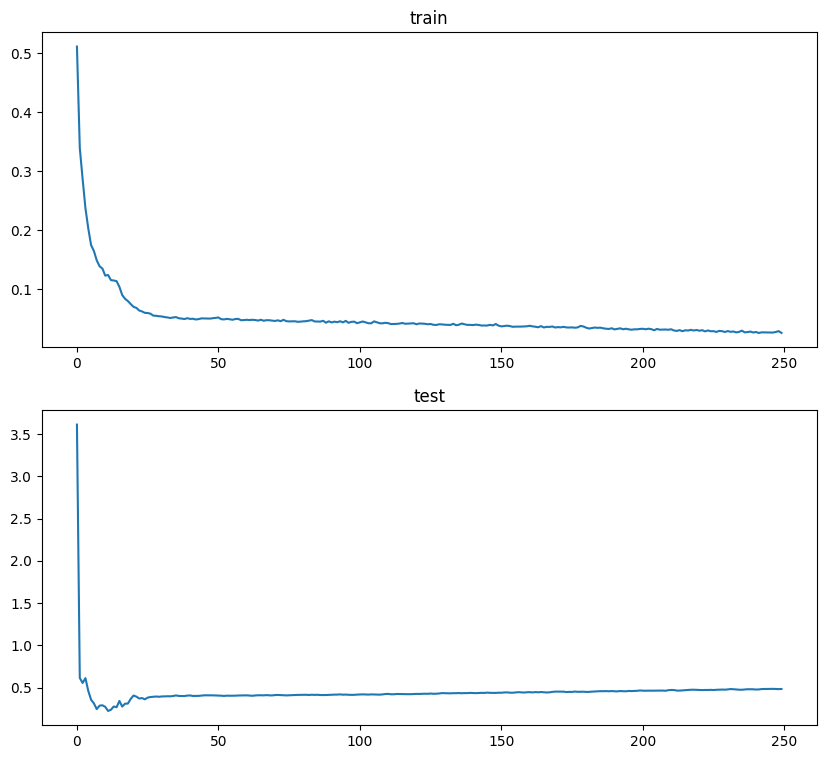

Epoch[250/250] | loss train:0.026398, test:0.482495


100%|███████████████████████████████████████████| 35/35 [00:02<00:00, 17.18it/s]


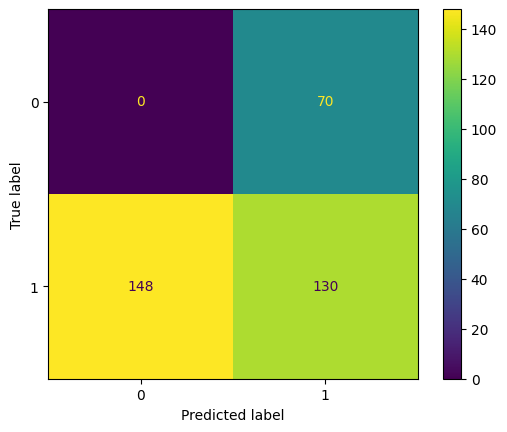

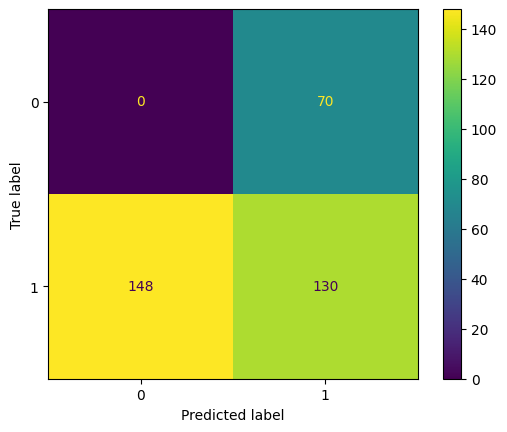

In [62]:
CrossValidationExperement(records, annots, times, all_labels, "./CrossValidationResults/MixedLeadsLastEpoch", True, True)

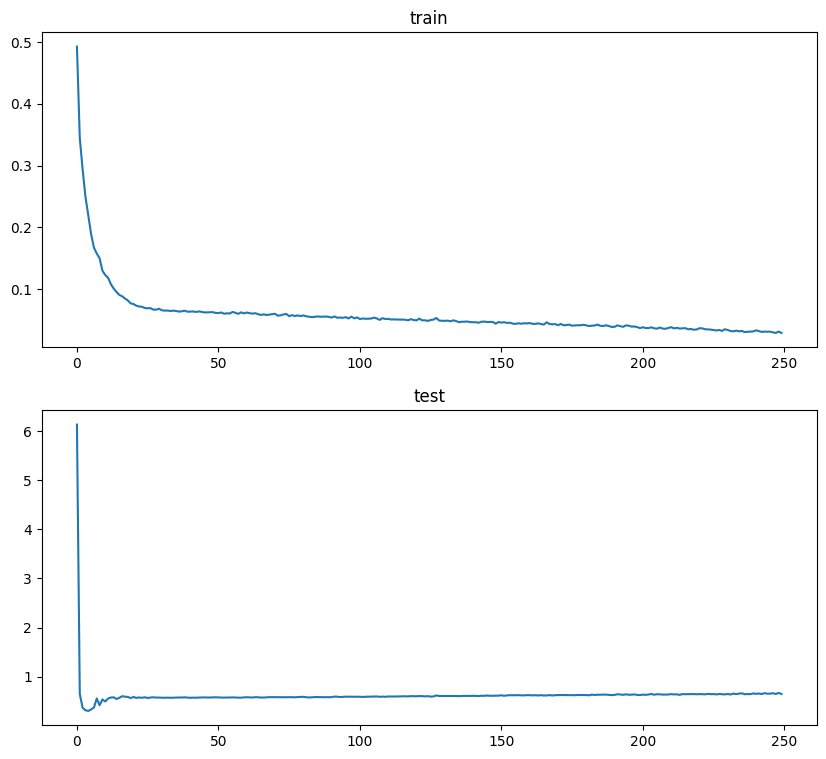

Epoch[250/250] | loss train:0.029196, test:0.646162


100%|███████████████████████████████████████████| 35/35 [00:02<00:00, 16.94it/s]


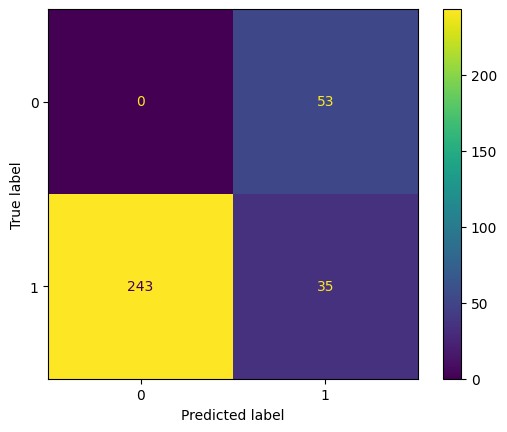

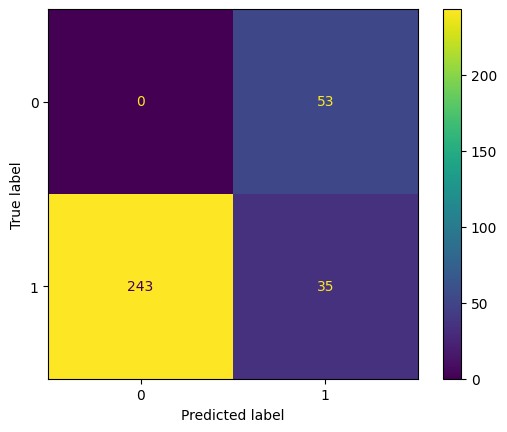

In [57]:
CrossValidationExperement(records, annots, times, all_labels, "./CrossValidationResults/MixedLeads", True, False)

In [80]:
all_labels[-2].max()

1.0